# Project-1
## Helper Code and Imports

### Index

* [Main Code](#Main-Code)
    * [Processinf Video](#Processing-Video)
    * [Processing Video w/o Slope](#Processing-Image-w/o-Slopes)
* [Challenge](#Challenge) - Incomplete
* [Reflection](#Reflection)

In [1]:
# Importing all necessary packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
import statistics as s
%matplotlib inline

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_custom(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


# def draw_lines_custom(img, lines, color=(255, 0, 0), thickness=7):
#     left_slope = []
#     left_lines = []
#     right_slope = []
#     right_lines = []
    
#     for line in lines:
#         for x1, y1, x2, y2 in line:
#             m = ((y1-y2)/(x1-x2)) # http://www.mathwarehouse.com/algebra/linear_equation/slope-of-a-line.php
#             if m <= -0.2:
#                 left_slope.append(m)
#                 left_lines.append((x1,y1))
#             elif m >= 0.2 and m <= 0.88:
#                 right_slope.append(m)
#                 right_lines.append((x2,y2))
                
# #     print(list(zip(*left_lines)))
    
#     # average left and right slopes
# #     right_slope = sorted(right_slope)[int(len(right_slope)/2)]
#     right_slope = np.mean(right_slope)
# # #     right_slope.astype(int)
# #     left_slope = sorted(left_slope)[int(len(left_slope)/2)]
#     left_slope = np.mean(left_slope)
# #     left_slope.astype(int)
# #     print(left_slope)
    
#     start_left_y = sorted([line[1] for line in left_lines])[int(len(left_lines)/2)]
#     start_left_x = [line[0] for line in left_lines if line[1] == start_left_y][0]

#     start_right_y = sorted([line[1] for line in right_lines])[int(len(right_lines)/2)]
#     start_right_x = [line[0] for line in right_lines if line[1] == start_right_y][0]
    
#     # Point of view extension
#     end_left_x = int((img.shape[1]-start_left_y)/left_slope) + start_left_x
#     end_right_x = int((img.shape[1]-start_right_y)/right_slope) + start_right_x
    
#     cv2.line(img, (start_left_x, start_left_y), (end_left_x, -img.shape[1]), color, thickness)
#     cv2.line(img, (start_right_x, start_right_y), (end_right_x, img.shape[1]), color, thickness)

In [3]:
def draw_lines_custom(img, lines, color=[255, 0, 0], thickness=7):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y1 - y2) / (x1 - x2)
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1 - slope * x1])
                    elif slope < 0:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1 - slope * x1])

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)

    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)

    # Plot lines
    draw_sep_lines(pos_coef, pos_intercept, intersection_x_coord, img, color, thickness)
    draw_sep_lines(neg_coef, neg_intercept, intersection_x_coord, img, color, thickness)


def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2 - intercept1) / (coef1 - coef2)
    return x


def draw_sep_lines(coef, intercept, intersection_x, img, color, thickness):
    """
    Draws lane.
    """

    imshape = img.shape
    # TODO: Remove the error for np.nan
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    point_two = 0
    if coef > 0:
        point_two = (imshape[1]-1, int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)

    test = new_coordinates(point_one, point_two)
    # test2 = (482,508)
    # test2 = new_coordinates((400,400), (600,200))

    # Draw line using cv2.line
    cv2.line(img, test, point_two, color, thickness)
    # cv2.line(img, (400,400), (600,200), [0,255,0], thickness)
    # cv2.line(img, (400,400), test2, [204,255,204], thickness)
    # cv2.line(img, point_one, point_two, color, thickness)
    print("--------------------------------------------------------------------------------------------------------")


# def new_coordinates(point_one, point_two):
#     print(("x1", point_one[0], "y1", point_one[1]), ("x2", point_two[0], "y2", point_two[1]))
#     distance = math.sqrt((point_two[0] - point_one[0]) ** 2 + (point_two[1] - point_one[1]) ** 2)
#     print("distance between point one and two", distance)
#
#     slope = (point_two[1] - point_one[1]) / (point_two[0] - point_one[0])
#     print("Slope", slope)
#
#     angle = math.atan(slope)
#     print("angle", angle)
#
#     a = math.sin(angle) * (distance/30)
#     print("a", a)
#     b = math.cos(angle) * (distance/30)
#     print("b", b)
#
#     x_a = point_one[0] + a
#     y_b = point_one[1] + b
#
#     print("New points", (int(x_a), int(y_b)))
#     new_distance = math.sqrt((int(x_a) - point_two[0]) ** 2 + (int(y_b) - point_two[1]) ** 2)
#     print("new distance", new_distance)
#     return int(x_a), int(y_b)

def new_coordinates(point_one, point_two):
    """
    Based on "The intercept theorem", also known as "Thales' theorem"
    https://en.wikipedia.org/wiki/Intercept_theorem

    """

    dx = (point_two[0] - point_one[0])
    dy = (point_two[1] - point_one[1])

    x_a = point_one[0] + dx/20
    y_b = point_one[1] + dy/20

    print("New points", (int(x_a), int(y_b)))

    return int(x_a), int(y_b)

def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...].
    Finds the best fit using slope and intercept.
    """

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    # print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        # print(slope - mean_slope, 1.5 * slope_std)
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    # print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

## Main Code

### Static Image

In [4]:
# Getting the image
try:
    image = mpimg.imread('test_images/solidWhiteRight.jpg')
except FileNotFoundError as e:
    print(e)
# plt.imshow(image)

In [5]:
# Converting the image into gray scale
gray_image = grayscale(image)
# plt.imshow(gray_image, cmap='gray')

In [6]:
# Applying Gaussian blur to the gray scaled image
kernel_size = 5
gaussian_blur_image = gaussian_blur(gray_image, kernel_size)
# plt.imshow(gaussian_blur_image, cmap='gray')

In [7]:
# Applying Canny transform to the image
low_threshold = 50
high_threshold = 150
edges_image = canny(gaussian_blur_image, low_threshold, high_threshold)
# plt.imshow(edges_image, cmap='gray')

Point one:  (482, 308) Point two:  (959, 612)
New points (505, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (0, 636)
New points (457, 324)
--------------------------------------------------------------------------------------------------------


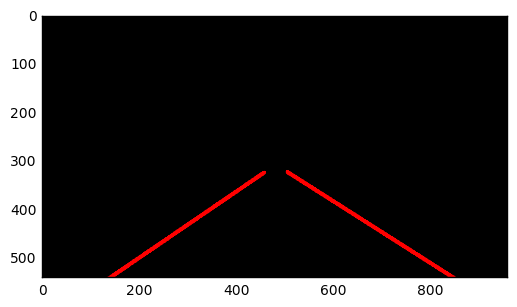

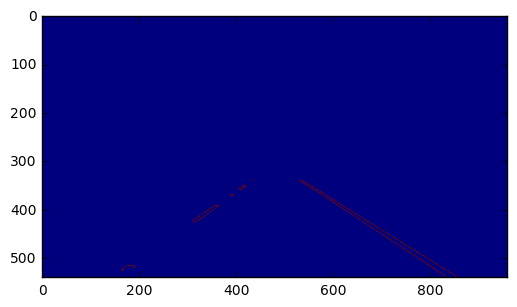

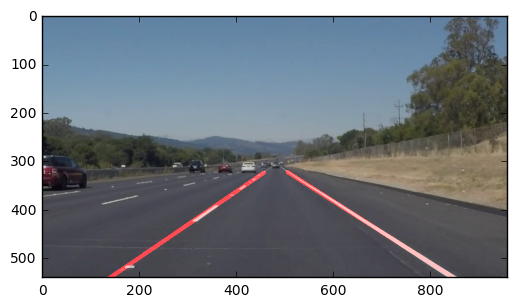

In [11]:
# Masking the image
imshape = image.shape
vertices = np.array([[(50, imshape[0]), (400, 340), (560, 340), (imshape[1], imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges_image, vertices)

# Applying Hough transform to masked image
rho = 2
theta = np.pi/180
threshold = 45
min_line_length = 40
max_line_gap = 100
hough_lines_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len=min_line_length, max_line_gap=max_line_gap)
combo_image = weighted_img(hough_lines_image, image)
# Display images
images = [hough_lines_image, masked_edges, combo_image]
for ima in images:
    plt.figure()
    plt.imshow(ima)

## Processing Video

In [12]:
def process_image(image):
    """
    Returns processed image.

    Applies the following filter/transforms
    ---------------------------------------

    * Gray Scale
    * Gaussian Blur
    * Canny Transform
    * Masking the image
    * Hough Transform

    The output of this function is the combition of Hough lines and original image.

    Example
    -------

    For image

    >>> try:
    >>>    image = mpimg.imread('test_images/solidWhiteRight.jpg')
    >>> except FileNotFoundError as e:
    >>>    print(e)
    >>> result = process_image(image)
    >>> plt.imshow(result)
    """

    # Converting the image into gray scale
    gray_image = grayscale(image)

    # Applying Gaussian blur to the gray scaled image
    kernel_size = 5
    gaussian_blur_image = gaussian_blur(gray_image, kernel_size)

    # Applying Canny transform to the image
    low_threshold = 50
    high_threshold = 150
    edges_image = canny(gaussian_blur_image, low_threshold, high_threshold)

    # Masking the image
    imshape = image.shape
    vertices = np.array([[(50, imshape[0]), (400, 340), (560, 340), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges_image, vertices)

    # Applying Hough transform to masked image
    rho = 2
    theta = np.pi/180
    threshold = 45
    min_line_length = 40
    max_line_gap = 100
    hough_lines_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len=min_line_length,
                                    max_line_gap=max_line_gap)
    result = weighted_img(hough_lines_image, image)

    return result

In [13]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Point one:  (480, 305) Point two:  (959, 596)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (0, 653)
New points (456, 322)
--------------------------------------------------------------------------------------------------------
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4



  0%|                                                                                                                                                                                        | 0/222 [00:00<?, ?it/s]

Point one:  (480, 305) Point two:  (959, 596)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (0, 653)
New points (456, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (959, 596)
New points (502, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (0, 649)
New points (454, 324)
--------------------------------------------------------------------------------------------------------



  1%|█▌                                                                                                                                                                              | 2/222 [00:00<00:16, 13.66it/s]

Point one:  (476, 302) Point two:  (959, 601)
New points (500, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 302) Point two:  (0, 665)
New points (452, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 305) Point two:  (959, 603)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 305) Point two:  (0, 650)
New points (455, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 306) Point two:  (959, 604)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 306) Point two:  (0, 645)
New points (455, 322)
-------------------------------------------------------------------------


  3%|████▊                                                                                                                                                                           | 6/222 [00:00<00:13, 16.38it/s]

Point one:  (478, 305) Point two:  (959, 599)
New points (502, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (0, 644)
New points (454, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 301) Point two:  (959, 599)
New points (503, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 301) Point two:  (0, 657)
New points (455, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 305) Point two:  (959, 599)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 305) Point two:  (0, 644)
New points (455, 321)
-------------------------------------------------------------------------


  4%|███████▏                                                                                                                                                                        | 9/222 [00:00<00:11, 18.57it/s]

Point one:  (478, 307) Point two:  (959, 599)
New points (502, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (0, 646)
New points (454, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 308) Point two:  (959, 606)
New points (500, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 308) Point two:  (0, 658)
New points (452, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 308) Point two:  (959, 609)
New points (497, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 308) Point two:  (0, 655)
New points (449, 325)
-------------------------------------------------------------------------


  6%|██████████▏                                                                                                                                                                    | 13/222 [00:00<00:09, 21.03it/s]

Point one:  (476, 305) Point two:  (959, 610)
New points (500, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 305) Point two:  (0, 659)
New points (452, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 307) Point two:  (959, 613)
New points (501, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 307) Point two:  (0, 645)
New points (453, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 302) Point two:  (959, 616)
New points (503, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 302) Point two:  (0, 643)
New points (455, 319)
-------------------------------------------------------------------------


  7%|████████████▌                                                                                                                                                                  | 16/222 [00:00<00:09, 22.69it/s]

Point one:  (480, 302) Point two:  (959, 609)
New points (503, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 302) Point two:  (0, 638)
New points (456, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 304) Point two:  (959, 608)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 304) Point two:  (0, 634)
New points (455, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (959, 614)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (0, 634)
New points (454, 323)
-------------------------------------------------------------------------


  9%|███████████████▊                                                                                                                                                               | 20/222 [00:00<00:08, 22.96it/s]

Point one:  (480, 307) Point two:  (959, 613)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 307) Point two:  (0, 640)
New points (456, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (959, 614)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (0, 648)
New points (456, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (959, 611)
New points (504, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (0, 637)
New points (456, 324)
-------------------------------------------------------------------------


 10%|██████████████████▏                                                                                                                                                            | 23/222 [00:00<00:08, 24.26it/s]

Point one:  (478, 306) Point two:  (959, 615)
New points (502, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 306) Point two:  (0, 647)
New points (454, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (959, 610)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (0, 646)
New points (456, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (959, 612)
New points (502, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (0, 647)
New points (454, 322)
-------------------------------------------------------------------------


 12%|████████████████████▍                                                                                                                                                          | 26/222 [00:01<00:07, 24.76it/s]

Point one:  (481, 306) Point two:  (959, 611)
New points (504, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (0, 640)
New points (456, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 307) Point two:  (959, 611)
New points (508, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 307) Point two:  (0, 640)
New points (460, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (959, 613)
New points (502, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (0, 658)
New points (454, 322)
-------------------------------------------------------------------------


 13%|██████████████████████▊                                                                                                                                                        | 29/222 [00:01<00:07, 24.60it/s]

Point one:  (478, 305) Point two:  (959, 612)
New points (502, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (0, 652)
New points (454, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 304) Point two:  (959, 610)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 304) Point two:  (0, 653)
New points (456, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 305) Point two:  (959, 612)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 305) Point two:  (0, 647)
New points (455, 322)
-------------------------------------------------------------------------


 14%|█████████████████████████▏                                                                                                                                                     | 32/222 [00:01<00:07, 24.67it/s]

Point one:  (480, 304) Point two:  (959, 610)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 304) Point two:  (0, 646)
New points (456, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 304) Point two:  (959, 608)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 304) Point two:  (0, 647)
New points (456, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (959, 606)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (0, 653)
New points (456, 322)
-------------------------------------------------------------------------


 16%|███████████████████████████▌                                                                                                                                                   | 35/222 [00:01<00:07, 25.80it/s]

Point one:  (481, 307) Point two:  (959, 613)
New points (504, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (0, 644)
New points (456, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (959, 611)
New points (504, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (0, 646)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 307) Point two:  (959, 611)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 307) Point two:  (0, 655)
New points (456, 324)
-------------------------------------------------------------------------


 17%|█████████████████████████████▉                                                                                                                                                 | 38/222 [00:01<00:07, 26.00it/s]

Point one:  (478, 304) Point two:  (959, 618)
New points (502, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 304) Point two:  (0, 656)
New points (454, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (959, 612)
New points (504, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (0, 646)
New points (456, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 303) Point two:  (959, 622)
New points (506, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 303) Point two:  (0, 641)
New points (458, 319)
-------------------------------------------------------------------------


 18%|████████████████████████████████▎                                                                                                                                              | 41/222 [00:01<00:07, 25.84it/s]

Point one:  (475, 302) Point two:  (959, 610)
New points (499, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 302) Point two:  (0, 665)
New points (451, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 301) Point two:  (959, 617)
New points (501, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 301) Point two:  (0, 655)
New points (453, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 301) Point two:  (959, 616)
New points (501, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 301) Point two:  (0, 654)
New points (453, 318)
-------------------------------------------------------------------------


 20%|███████████████████████████████████▍                                                                                                                                           | 45/222 [00:01<00:06, 26.80it/s]

Point one:  (482, 300) Point two:  (959, 619)
New points (505, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 300) Point two:  (0, 643)
New points (457, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 300) Point two:  (959, 616)
New points (501, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 300) Point two:  (0, 659)
New points (453, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 300) Point two:  (959, 615)
New points (500, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 300) Point two:  (0, 653)
New points (452, 317)
-------------------------------------------------------------------------


 22%|█████████████████████████████████████▊                                                                                                                                         | 48/222 [00:01<00:08, 19.52it/s]

Point one:  (475, 300) Point two:  (959, 615)
New points (499, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 300) Point two:  (0, 658)
New points (451, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 301) Point two:  (959, 613)
New points (501, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 301) Point two:  (0, 648)
New points (453, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 302) Point two:  (959, 614)
New points (503, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 302) Point two:  (0, 645)
New points (455, 319)
-------------------------------------------------------------------------


 23%|████████████████████████████████████████▉                                                                                                                                      | 52/222 [00:02<00:09, 17.30it/s]

Point one:  (478, 301) Point two:  (959, 618)
New points (502, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 301) Point two:  (0, 639)
New points (454, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 303) Point two:  (959, 606)
New points (499, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 303) Point two:  (0, 641)
New points (451, 319)
--------------------------------------------------------------------------------------------------------



 24%|██████████████████████████████████████████▌                                                                                                                                    | 54/222 [00:02<00:11, 14.76it/s]

Point one:  (475, 303) Point two:  (959, 610)
New points (499, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 303) Point two:  (0, 641)
New points (451, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 302) Point two:  (959, 617)
New points (503, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 302) Point two:  (0, 634)
New points (455, 318)
--------------------------------------------------------------------------------------------------------



 25%|████████████████████████████████████████████▏                                                                                                                                  | 56/222 [00:02<00:12, 13.03it/s]

Point one:  (476, 307) Point two:  (959, 612)
New points (500, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 307) Point two:  (0, 633)
New points (452, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 306) Point two:  (959, 609)
New points (499, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 306) Point two:  (0, 637)
New points (451, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 306) Point two:  (959, 612)
New points (499, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 306) Point two:  (0, 642)
New points (451, 322)
-------------------------------------------------------------------------


 27%|██████████████████████████████████████████████▌                                                                                                                                | 59/222 [00:02<00:11, 13.88it/s]

Point one:  (478, 303) Point two:  (959, 618)
New points (502, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 303) Point two:  (0, 637)
New points (454, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (959, 618)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (0, 634)
New points (456, 321)
--------------------------------------------------------------------------------------------------------



 27%|████████████████████████████████████████████████                                                                                                                               | 61/222 [00:03<00:16, 10.03it/s]

Point one:  (479, 304) Point two:  (959, 620)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 304) Point two:  (0, 634)
New points (455, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (959, 617)
New points (502, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (0, 645)
New points (454, 322)
--------------------------------------------------------------------------------------------------------



 28%|█████████████████████████████████████████████████▋                                                                                                                             | 63/222 [00:03<00:14, 10.67it/s]

Point one:  (481, 305) Point two:  (959, 626)
New points (504, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 305) Point two:  (0, 627)
New points (456, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (959, 621)
New points (502, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (0, 633)
New points (454, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (959, 620)
New points (504, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (0, 624)
New points (456, 321)
-------------------------------------------------------------------------


 30%|████████████████████████████████████████████████████                                                                                                                           | 66/222 [00:03<00:12, 12.76it/s]

Point one:  (480, 302) Point two:  (959, 622)
New points (503, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 302) Point two:  (0, 626)
New points (456, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 306) Point two:  (959, 617)
New points (502, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 306) Point two:  (0, 621)
New points (454, 321)
--------------------------------------------------------------------------------------------------------



 31%|█████████████████████████████████████████████████████▌                                                                                                                         | 68/222 [00:03<00:14, 10.68it/s]

Point one:  (477, 304) Point two:  (959, 621)
New points (501, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 304) Point two:  (0, 630)
New points (453, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 303) Point two:  (959, 621)
New points (500, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 303) Point two:  (0, 640)
New points (452, 319)
--------------------------------------------------------------------------------------------------------



 32%|███████████████████████████████████████████████████████▏                                                                                                                       | 70/222 [00:03<00:13, 11.04it/s]

Point one:  (477, 303) Point two:  (959, 622)
New points (501, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 303) Point two:  (0, 633)
New points (453, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 303) Point two:  (959, 624)
New points (502, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 303) Point two:  (0, 629)
New points (454, 319)
--------------------------------------------------------------------------------------------------------



 32%|████████████████████████████████████████████████████████▊                                                                                                                      | 72/222 [00:04<00:14, 10.06it/s]

Point one:  (477, 304) Point two:  (959, 621)
New points (501, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 304) Point two:  (0, 633)
New points (453, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 304) Point two:  (959, 622)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 304) Point two:  (0, 632)
New points (455, 320)
--------------------------------------------------------------------------------------------------------



 33%|██████████████████████████████████████████████████████████▎                                                                                                                    | 74/222 [00:04<00:14, 10.25it/s]

Point one:  (478, 305) Point two:  (959, 621)
New points (502, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (0, 627)
New points (454, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 302) Point two:  (959, 620)
New points (501, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 302) Point two:  (0, 627)
New points (453, 318)
--------------------------------------------------------------------------------------------------------



 34%|███████████████████████████████████████████████████████████▉                                                                                                                   | 76/222 [00:04<00:13, 10.60it/s]

Point one:  (476, 306) Point two:  (959, 623)
New points (500, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 306) Point two:  (0, 619)
New points (452, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 303) Point two:  (959, 626)
New points (497, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 303) Point two:  (0, 634)
New points (449, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (959, 632)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (0, 619)
New points (456, 321)
-------------------------------------------------------------------------


 36%|██████████████████████████████████████████████████████████████▎                                                                                                                | 79/222 [00:04<00:12, 11.66it/s]

Point one:  (476, 307) Point two:  (959, 635)
New points (500, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 307) Point two:  (0, 614)
New points (452, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (959, 631)
New points (502, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (0, 620)
New points (454, 320)
--------------------------------------------------------------------------------------------------------



 36%|███████████████████████████████████████████████████████████████▊                                                                                                               | 81/222 [00:04<00:10, 13.18it/s]

Point one:  (477, 305) Point two:  (959, 620)
New points (501, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 305) Point two:  (0, 620)
New points (453, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 305) Point two:  (959, 627)
New points (501, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 305) Point two:  (0, 617)
New points (453, 320)
--------------------------------------------------------------------------------------------------------



 37%|█████████████████████████████████████████████████████████████████▍                                                                                                             | 83/222 [00:05<00:14,  9.92it/s]

Point one:  (478, 305) Point two:  (959, 621)
New points (502, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (0, 618)
New points (454, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 304) Point two:  (959, 628)
New points (507, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 304) Point two:  (0, 612)
New points (459, 319)
--------------------------------------------------------------------------------------------------------



 38%|███████████████████████████████████████████████████████████████████                                                                                                            | 85/222 [00:05<00:12, 10.98it/s]

Point one:  (481, 307) Point two:  (959, 629)
New points (504, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (0, 615)
New points (456, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 303) Point two:  (959, 632)
New points (504, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 303) Point two:  (0, 619)
New points (456, 318)
--------------------------------------------------------------------------------------------------------



 39%|████████████████████████████████████████████████████████████████████▌                                                                                                          | 87/222 [00:05<00:10, 12.52it/s]

Point one:  (478, 306) Point two:  (959, 630)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 306) Point two:  (0, 626)
New points (454, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (959, 635)
New points (504, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (0, 615)
New points (456, 321)
--------------------------------------------------------------------------------------------------------



 40%|██████████████████████████████████████████████████████████████████████▏                                                                                                        | 89/222 [00:05<00:11, 12.07it/s]

Point one:  (480, 305) Point two:  (959, 635)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (0, 622)
New points (456, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 306) Point two:  (959, 635)
New points (507, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 306) Point two:  (0, 611)
New points (459, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (959, 630)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (0, 624)
New points (455, 322)
-------------------------------------------------------------------------


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                      | 92/222 [00:05<00:09, 13.51it/s]

Point one:  (483, 304) Point two:  (959, 643)
New points (506, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 304) Point two:  (0, 623)
New points (458, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 306) Point two:  (959, 638)
New points (505, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 306) Point two:  (0, 618)
New points (457, 321)
--------------------------------------------------------------------------------------------------------



 42%|██████████████████████████████████████████████████████████████████████████                                                                                                     | 94/222 [00:05<00:09, 12.91it/s]

Point one:  (482, 305) Point two:  (959, 629)
New points (505, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 305) Point two:  (0, 623)
New points (457, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (959, 627)
New points (504, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (0, 618)
New points (456, 322)
--------------------------------------------------------------------------------------------------------



 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                   | 96/222 [00:06<00:12,  9.95it/s]

Point one:  (483, 302) Point two:  (959, 634)
New points (506, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 302) Point two:  (0, 624)
New points (458, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 303) Point two:  (959, 633)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 303) Point two:  (0, 627)
New points (456, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 302) Point two:  (959, 632)
New points (507, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 302) Point two:  (0, 622)
New points (459, 318)
-------------------------------------------------------------------------


 45%|██████████████████████████████████████████████████████████████████████████████▍                                                                                               | 100/222 [00:06<00:10, 11.64it/s]

Point one:  (481, 300) Point two:  (959, 634)
New points (504, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 300) Point two:  (0, 625)
New points (456, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 302) Point two:  (959, 639)
New points (506, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 302) Point two:  (0, 635)
New points (458, 318)
--------------------------------------------------------------------------------------------------------



 46%|███████████████████████████████████████████████████████████████████████████████▉                                                                                              | 102/222 [00:06<00:10, 11.25it/s]

Point one:  (484, 309) Point two:  (959, 635)
New points (507, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 309) Point two:  (0, 617)
New points (459, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 305) Point two:  (959, 625)
New points (504, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 305) Point two:  (0, 636)
New points (456, 321)
--------------------------------------------------------------------------------------------------------



 47%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 104/222 [00:06<00:09, 12.77it/s]

Point one:  (483, 303) Point two:  (959, 631)
New points (506, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 303) Point two:  (0, 641)
New points (458, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 305) Point two:  (959, 622)
New points (507, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 305) Point two:  (0, 628)
New points (459, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 303) Point two:  (959, 616)
New points (505, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 303) Point two:  (0, 635)
New points (457, 319)
-------------------------------------------------------------------------


 48%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 107/222 [00:06<00:10, 11.50it/s]

Point one:  (483, 302) Point two:  (959, 629)
New points (506, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 302) Point two:  (0, 634)
New points (458, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 304) Point two:  (959, 630)
New points (509, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 304) Point two:  (0, 631)
New points (461, 320)
--------------------------------------------------------------------------------------------------------



 49%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 109/222 [00:07<00:10, 11.18it/s]

Point one:  (483, 303) Point two:  (959, 625)
New points (506, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 303) Point two:  (0, 635)
New points (458, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 304) Point two:  (959, 629)
New points (508, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 304) Point two:  (0, 634)
New points (460, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 300) Point two:  (959, 628)
New points (505, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 300) Point two:  (0, 650)
New points (457, 317)
-------------------------------------------------------------------------


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 112/222 [00:07<00:09, 11.62it/s]

Point one:  (482, 299) Point two:  (959, 627)
New points (505, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 299) Point two:  (0, 645)
New points (457, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 301) Point two:  (959, 619)
New points (505, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 301) Point two:  (0, 644)
New points (457, 318)
--------------------------------------------------------------------------------------------------------



 51%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 114/222 [00:07<00:09, 11.72it/s]

Point one:  (486, 300) Point two:  (959, 624)
New points (509, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 300) Point two:  (0, 633)
New points (461, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 303) Point two:  (959, 619)
New points (506, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 303) Point two:  (0, 625)
New points (458, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 301) Point two:  (959, 620)
New points (508, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 301) Point two:  (0, 627)
New points (460, 317)
-------------------------------------------------------------------------


 53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 117/222 [00:07<00:07, 14.20it/s]

Point one:  (481, 300) Point two:  (959, 620)
New points (504, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 300) Point two:  (0, 642)
New points (456, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 304) Point two:  (959, 621)
New points (509, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 304) Point two:  (0, 621)
New points (461, 319)
--------------------------------------------------------------------------------------------------------



 54%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 119/222 [00:08<00:10,  9.54it/s]

Point one:  (484, 301) Point two:  (959, 629)
New points (507, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 301) Point two:  (0, 636)
New points (459, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 304) Point two:  (959, 618)
New points (507, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 304) Point two:  (0, 631)
New points (459, 320)
--------------------------------------------------------------------------------------------------------



 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 121/222 [00:08<00:09, 10.31it/s]

Point one:  (482, 305) Point two:  (959, 614)
New points (505, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 305) Point two:  (0, 633)
New points (457, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (487, 306) Point two:  (959, 615)
New points (510, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (487, 306) Point two:  (0, 629)
New points (462, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 304) Point two:  (959, 613)
New points (508, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 304) Point two:  (0, 641)
New points (460, 320)
-------------------------------------------------------------------------


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 124/222 [00:08<00:08, 11.45it/s]

Point one:  (483, 303) Point two:  (959, 611)
New points (506, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 303) Point two:  (0, 642)
New points (458, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 308) Point two:  (959, 610)
New points (507, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 308) Point two:  (0, 631)
New points (459, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (487, 308) Point two:  (959, 610)
New points (510, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (487, 308) Point two:  (0, 624)
New points (462, 323)
-------------------------------------------------------------------------


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 127/222 [00:08<00:07, 12.04it/s]

Point one:  (483, 306) Point two:  (959, 612)
New points (506, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 306) Point two:  (0, 639)
New points (458, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 306) Point two:  (959, 612)
New points (506, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 306) Point two:  (0, 638)
New points (458, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 305) Point two:  (959, 609)
New points (506, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 305) Point two:  (0, 648)
New points (458, 322)
-------------------------------------------------------------------------


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 130/222 [00:08<00:07, 12.69it/s]

Point one:  (486, 307) Point two:  (959, 610)
New points (509, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 307) Point two:  (0, 640)
New points (461, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 307) Point two:  (959, 610)
New points (507, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 307) Point two:  (0, 650)
New points (459, 324)
--------------------------------------------------------------------------------------------------------



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 132/222 [00:09<00:08, 10.40it/s]

Point one:  (486, 306) Point two:  (959, 602)
New points (509, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 306) Point two:  (0, 647)
New points (461, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 303) Point two:  (959, 613)
New points (505, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 303) Point two:  (0, 650)
New points (457, 320)
--------------------------------------------------------------------------------------------------------



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 134/222 [00:09<00:07, 11.39it/s]

Point one:  (479, 303) Point two:  (959, 610)
New points (503, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 303) Point two:  (0, 651)
New points (455, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 304) Point two:  (959, 606)
New points (508, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 304) Point two:  (0, 642)
New points (460, 320)
--------------------------------------------------------------------------------------------------------



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 136/222 [00:09<00:06, 13.06it/s]

Point one:  (481, 300) Point two:  (959, 604)
New points (504, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 300) Point two:  (0, 654)
New points (456, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 303) Point two:  (959, 603)
New points (506, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 303) Point two:  (0, 647)
New points (458, 320)
--------------------------------------------------------------------------------------------------------



 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 138/222 [00:09<00:06, 12.51it/s]

Point one:  (481, 301) Point two:  (959, 604)
New points (504, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 301) Point two:  (0, 659)
New points (456, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 304) Point two:  (959, 603)
New points (507, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 304) Point two:  (0, 649)
New points (459, 321)
--------------------------------------------------------------------------------------------------------



 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 140/222 [00:09<00:07, 10.79it/s]

Point one:  (482, 306) Point two:  (959, 602)
New points (505, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 306) Point two:  (0, 648)
New points (457, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 304) Point two:  (959, 608)
New points (506, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 304) Point two:  (0, 660)
New points (458, 321)
--------------------------------------------------------------------------------------------------------



 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 142/222 [00:09<00:06, 11.57it/s]

Point one:  (483, 306) Point two:  (959, 610)
New points (506, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 306) Point two:  (0, 657)
New points (458, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (959, 609)
New points (506, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (0, 655)
New points (458, 325)
--------------------------------------------------------------------------------------------------------



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 144/222 [00:10<00:07,  9.89it/s]

Point one:  (484, 306) Point two:  (959, 608)
New points (507, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 306) Point two:  (0, 650)
New points (459, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (487, 304) Point two:  (959, 605)
New points (510, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (487, 304) Point two:  (0, 652)
New points (462, 321)
--------------------------------------------------------------------------------------------------------



 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 146/222 [00:10<00:07, 10.11it/s]

Point one:  (484, 303) Point two:  (959, 604)
New points (507, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 303) Point two:  (0, 660)
New points (459, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 305) Point two:  (959, 599)
New points (504, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 305) Point two:  (0, 655)
New points (456, 322)
--------------------------------------------------------------------------------------------------------



 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 148/222 [00:10<00:06, 11.43it/s]

Point one:  (483, 301) Point two:  (959, 604)
New points (506, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 301) Point two:  (0, 661)
New points (458, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 303) Point two:  (959, 602)
New points (508, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 303) Point two:  (0, 657)
New points (460, 320)
--------------------------------------------------------------------------------------------------------



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 150/222 [00:10<00:07,  9.80it/s]

Point one:  (484, 306) Point two:  (959, 597)
New points (507, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 306) Point two:  (0, 652)
New points (459, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 304) Point two:  (959, 602)
New points (506, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 304) Point two:  (0, 661)
New points (458, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 306) Point two:  (959, 599)
New points (508, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 306) Point two:  (0, 648)
New points (460, 323)
-------------------------------------------------------------------------


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 153/222 [00:10<00:06, 10.87it/s]

Point one:  (485, 302) Point two:  (959, 600)
New points (508, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 302) Point two:  (0, 663)
New points (460, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (488, 302) Point two:  (959, 597)
New points (511, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (488, 302) Point two:  (0, 657)
New points (463, 319)
--------------------------------------------------------------------------------------------------------



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 155/222 [00:11<00:06,  9.75it/s]

Point one:  (487, 300) Point two:  (959, 601)
New points (510, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (487, 300) Point two:  (0, 666)
New points (462, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 302) Point two:  (959, 601)
New points (509, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 302) Point two:  (0, 658)
New points (461, 319)
--------------------------------------------------------------------------------------------------------



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 157/222 [00:11<00:06,  9.65it/s]

Point one:  (484, 303) Point two:  (959, 595)
New points (507, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 303) Point two:  (0, 661)
New points (459, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 302) Point two:  (959, 596)
New points (507, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 302) Point two:  (0, 664)
New points (459, 320)
--------------------------------------------------------------------------------------------------------



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 159/222 [00:11<00:06, 10.28it/s]

Point one:  (484, 303) Point two:  (959, 594)
New points (507, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 303) Point two:  (0, 660)
New points (459, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (488, 306) Point two:  (959, 589)
New points (511, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (488, 306) Point two:  (0, 655)
New points (463, 323)
--------------------------------------------------------------------------------------------------------



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 161/222 [00:11<00:06,  9.89it/s]

Point one:  (486, 305) Point two:  (959, 593)
New points (509, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 305) Point two:  (0, 666)
New points (461, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (959, 576)
New points (506, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (0, 664)
New points (458, 325)
--------------------------------------------------------------------------------------------------------



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 163/222 [00:12<00:06,  9.26it/s]

Point one:  (484, 305) Point two:  (959, 586)
New points (507, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 305) Point two:  (0, 674)
New points (459, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 306) Point two:  (959, 587)
New points (506, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 306) Point two:  (0, 676)
New points (458, 324)
--------------------------------------------------------------------------------------------------------



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 165/222 [00:12<00:05, 10.20it/s]

Point one:  (485, 307) Point two:  (959, 592)
New points (508, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 307) Point two:  (0, 671)
New points (460, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (959, 588)
New points (506, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (0, 681)
New points (458, 325)
--------------------------------------------------------------------------------------------------------



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 167/222 [00:12<00:07,  7.59it/s]

Point one:  (479, 304) Point two:  (959, 587)
New points (503, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 304) Point two:  (0, 693)
New points (455, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (959, 591)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (0, 677)
New points (456, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 307) Point two:  (959, 589)
New points (507, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 307) Point two:  (0, 676)
New points (459, 325)
-------------------------------------------------------------------------


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 171/222 [00:12<00:05,  9.74it/s]

Point one:  (482, 307) Point two:  (959, 589)
New points (505, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 307) Point two:  (0, 679)
New points (457, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 309) Point two:  (959, 592)
New points (506, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 309) Point two:  (0, 675)
New points (458, 327)
--------------------------------------------------------------------------------------------------------



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 173/222 [00:13<00:06,  8.12it/s]

Point one:  (480, 305) Point two:  (959, 585)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (0, 687)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 304) Point two:  (959, 585)
New points (504, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 304) Point two:  (0, 687)
New points (456, 323)
--------------------------------------------------------------------------------------------------------



 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 175/222 [00:13<00:05,  8.63it/s]

Point one:  (480, 306) Point two:  (959, 589)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (0, 682)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (959, 586)
New points (505, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (0, 683)
New points (457, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 307) Point two:  (959, 586)
New points (505, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 307) Point two:  (0, 681)
New points (457, 325)
-------------------------------------------------------------------------


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 178/222 [00:13<00:04,  9.58it/s]

Point one:  (480, 306) Point two:  (959, 593)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (0, 692)
New points (456, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 303) Point two:  (959, 594)
New points (505, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 303) Point two:  (0, 689)
New points (457, 322)
--------------------------------------------------------------------------------------------------------



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 180/222 [00:13<00:04, 10.04it/s]

Point one:  (482, 305) Point two:  (959, 584)
New points (505, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 305) Point two:  (0, 687)
New points (457, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 304) Point two:  (959, 584)
New points (506, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 304) Point two:  (0, 687)
New points (458, 323)
--------------------------------------------------------------------------------------------------------



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 182/222 [00:13<00:03, 10.96it/s]

Point one:  (483, 304) Point two:  (959, 586)
New points (506, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 304) Point two:  (0, 689)
New points (458, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 305) Point two:  (959, 587)
New points (505, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 305) Point two:  (0, 690)
New points (457, 324)
--------------------------------------------------------------------------------------------------------



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 184/222 [00:14<00:03, 10.02it/s]

Point one:  (483, 302) Point two:  (959, 589)
New points (506, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 302) Point two:  (0, 690)
New points (458, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 301) Point two:  (959, 589)
New points (504, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 301) Point two:  (0, 697)
New points (456, 320)
--------------------------------------------------------------------------------------------------------



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 186/222 [00:14<00:03,  9.36it/s]

Point one:  (482, 304) Point two:  (959, 585)
New points (505, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 304) Point two:  (0, 688)
New points (457, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 303) Point two:  (959, 587)
New points (504, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 303) Point two:  (0, 686)
New points (456, 322)
--------------------------------------------------------------------------------------------------------



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 188/222 [00:14<00:03, 10.49it/s]

Point one:  (483, 300) Point two:  (959, 581)
New points (506, 314)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 300) Point two:  (0, 682)
New points (458, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 298) Point two:  (959, 577)
New points (507, 311)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 298) Point two:  (0, 679)
New points (459, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 300) Point two:  (959, 577)
New points (504, 313)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 300) Point two:  (0, 690)
New points (456, 319)
-------------------------------------------------------------------------


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 191/222 [00:14<00:02, 11.27it/s]

Point one:  (482, 303) Point two:  (959, 574)
New points (505, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 303) Point two:  (0, 679)
New points (457, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 304) Point two:  (959, 579)
New points (504, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 304) Point two:  (0, 693)
New points (456, 323)
--------------------------------------------------------------------------------------------------------



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 193/222 [00:15<00:03,  7.47it/s]

Point one:  (482, 305) Point two:  (959, 578)
New points (505, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 305) Point two:  (0, 691)
New points (457, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 306) Point two:  (959, 591)
New points (508, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 306) Point two:  (0, 683)
New points (460, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 305) Point two:  (959, 587)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 305) Point two:  (0, 695)
New points (455, 324)
-------------------------------------------------------------------------


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 196/222 [00:15<00:02,  9.62it/s]

Point one:  (480, 305) Point two:  (959, 588)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (0, 683)
New points (456, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 303) Point two:  (959, 590)
New points (506, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 303) Point two:  (0, 689)
New points (458, 322)
--------------------------------------------------------------------------------------------------------



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 198/222 [00:15<00:02,  8.97it/s]

Point one:  (479, 303) Point two:  (959, 584)
New points (503, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 303) Point two:  (0, 694)
New points (455, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (959, 578)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (0, 686)
New points (456, 325)
--------------------------------------------------------------------------------------------------------



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 200/222 [00:15<00:02,  9.26it/s]

Point one:  (478, 306) Point two:  (959, 578)
New points (502, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 306) Point two:  (0, 688)
New points (454, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 303) Point two:  (959, 583)
New points (502, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 303) Point two:  (0, 693)
New points (454, 322)
--------------------------------------------------------------------------------------------------------



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 202/222 [00:15<00:01, 10.02it/s]

Point one:  (483, 305) Point two:  (959, 582)
New points (506, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 305) Point two:  (0, 680)
New points (458, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 304) Point two:  (959, 575)
New points (502, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 304) Point two:  (0, 692)
New points (454, 323)
--------------------------------------------------------------------------------------------------------



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 204/222 [00:16<00:02,  7.08it/s]

Point one:  (480, 305) Point two:  (959, 578)
New points (503, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (0, 681)
New points (456, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 303) Point two:  (959, 576)
New points (503, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 303) Point two:  (0, 692)
New points (456, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 302) Point two:  (959, 576)
New points (504, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 302) Point two:  (0, 691)
New points (456, 321)
-------------------------------------------------------------------------


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 207/222 [00:16<00:01,  8.23it/s]

Point one:  (479, 302) Point two:  (959, 573)
New points (503, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 302) Point two:  (0, 686)
New points (455, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 302) Point two:  (959, 577)
New points (500, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 302) Point two:  (0, 707)
New points (452, 322)
--------------------------------------------------------------------------------------------------------



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 209/222 [00:17<00:02,  5.64it/s]

Point one:  (480, 304) Point two:  (959, 575)
New points (503, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 304) Point two:  (0, 682)
New points (456, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 303) Point two:  (959, 574)
New points (504, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 303) Point two:  (0, 688)
New points (456, 322)
--------------------------------------------------------------------------------------------------------



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 211/222 [00:17<00:01,  6.16it/s]

Point one:  (479, 305) Point two:  (959, 576)
New points (503, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 305) Point two:  (0, 686)
New points (455, 324)
--------------------------------------------------------------------------------------------------------



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 212/222 [00:18<00:03,  3.14it/s]

Point one:  (478, 303) Point two:  (959, 577)
New points (502, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 303) Point two:  (0, 697)
New points (454, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 306) Point two:  (959, 578)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 306) Point two:  (0, 691)
New points (455, 325)
--------------------------------------------------------------------------------------------------------



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 214/222 [00:18<00:02,  3.90it/s]

Point one:  (482, 308) Point two:  (959, 578)
New points (505, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (0, 673)
New points (457, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 308) Point two:  (959, 577)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 308) Point two:  (0, 684)
New points (455, 326)
--------------------------------------------------------------------------------------------------------



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 216/222 [00:18<00:01,  4.97it/s]

Point one:  (475, 306) Point two:  (959, 580)
New points (499, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 306) Point two:  (0, 691)
New points (451, 325)
--------------------------------------------------------------------------------------------------------



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 217/222 [00:18<00:01,  4.07it/s]

Point one:  (477, 307) Point two:  (959, 579)
New points (501, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 307) Point two:  (0, 690)
New points (453, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (959, 583)
New points (501, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (0, 681)
New points (453, 326)
--------------------------------------------------------------------------------------------------------



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 219/222 [00:19<00:00,  4.70it/s]

Point one:  (475, 305) Point two:  (959, 580)
New points (499, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 305) Point two:  (0, 688)
New points (451, 324)
--------------------------------------------------------------------------------------------------------



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 220/222 [00:19<00:00,  4.55it/s]

Point one:  (475, 305) Point two:  (959, 581)
New points (499, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 305) Point two:  (0, 686)
New points (451, 324)
--------------------------------------------------------------------------------------------------------



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 221/222 [00:19<00:00,  5.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 21.7 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [15]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Point one:  (490, 308) Point two:  (959, 625)
New points (513, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (490, 308) Point two:  (0, 609)
New points (465, 323)
--------------------------------------------------------------------------------------------------------
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



  0%|                                                                                                                                                                                        | 0/682 [00:00<?, ?it/s]

Point one:  (490, 308) Point two:  (959, 625)
New points (513, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (490, 308) Point two:  (0, 609)
New points (465, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (492, 308) Point two:  (959, 632)
New points (515, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (492, 308) Point two:  (0, 610)
New points (467, 323)
--------------------------------------------------------------------------------------------------------



  0%|▌                                                                                                                                                                               | 2/682 [00:00<00:40, 16.98it/s]

Point one:  (491, 307) Point two:  (959, 632)
New points (514, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (491, 307) Point two:  (0, 609)
New points (466, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 305) Point two:  (959, 627)
New points (508, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 305) Point two:  (0, 616)
New points (460, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 305) Point two:  (959, 624)
New points (508, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 305) Point two:  (0, 616)
New points (460, 320)
-------------------------------------------------------------------------


  1%|█▎                                                                                                                                                                              | 5/682 [00:00<00:34, 19.47it/s]

Point one:  (494, 303) Point two:  (959, 646)
New points (517, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (494, 303) Point two:  (0, 617)
New points (469, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (491, 306) Point two:  (959, 629)
New points (514, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (491, 306) Point two:  (0, 624)
New points (466, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (489, 308) Point two:  (959, 616)
New points (512, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (489, 308) Point two:  (0, 619)
New points (464, 323)
-------------------------------------------------------------------------


  1%|██                                                                                                                                                                              | 8/682 [00:00<00:31, 21.61it/s]

Point one:  (488, 305) Point two:  (959, 617)
New points (511, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (488, 305) Point two:  (0, 632)
New points (463, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (487, 305) Point two:  (959, 615)
New points (510, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (487, 305) Point two:  (0, 629)
New points (462, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (490, 302) Point two:  (959, 627)
New points (513, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (490, 302) Point two:  (0, 632)
New points (465, 318)
-------------------------------------------------------------------------


  2%|██▊                                                                                                                                                                            | 11/682 [00:00<00:28, 23.41it/s]

Point one:  (485, 304) Point two:  (959, 612)
New points (508, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 304) Point two:  (0, 626)
New points (460, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 306) Point two:  (959, 607)
New points (509, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 306) Point two:  (0, 627)
New points (461, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 307) Point two:  (959, 609)
New points (508, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 307) Point two:  (0, 631)
New points (460, 323)
-------------------------------------------------------------------------


  2%|███▌                                                                                                                                                                           | 14/682 [00:00<00:27, 24.49it/s]

Point one:  (483, 310) Point two:  (959, 599)
New points (506, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 310) Point two:  (0, 635)
New points (458, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 306) Point two:  (959, 601)
New points (505, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 306) Point two:  (0, 635)
New points (457, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 304) Point two:  (959, 613)
New points (509, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 304) Point two:  (0, 639)
New points (461, 320)
-------------------------------------------------------------------------


  2%|████▎                                                                                                                                                                          | 17/682 [00:00<00:26, 24.68it/s]

Point one:  (484, 306) Point two:  (959, 608)
New points (507, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 306) Point two:  (0, 638)
New points (459, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 305) Point two:  (959, 612)
New points (509, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 305) Point two:  (0, 637)
New points (461, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (488, 304) Point two:  (959, 615)
New points (511, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (488, 304) Point two:  (0, 638)
New points (463, 320)
-------------------------------------------------------------------------


  3%|█████▍                                                                                                                                                                         | 21/682 [00:00<00:25, 26.38it/s]

Point one:  (485, 304) Point two:  (959, 607)
New points (508, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 304) Point two:  (0, 637)
New points (460, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 303) Point two:  (959, 612)
New points (508, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 303) Point two:  (0, 636)
New points (460, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 304) Point two:  (959, 598)
New points (504, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 304) Point two:  (0, 631)
New points (456, 320)
-------------------------------------------------------------------------


  4%|██████▏                                                                                                                                                                        | 24/682 [00:00<00:24, 26.37it/s]

Point one:  (484, 303) Point two:  (959, 610)
New points (507, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 303) Point two:  (0, 638)
New points (459, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 303) Point two:  (959, 607)
New points (507, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 303) Point two:  (0, 648)
New points (459, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 305) Point two:  (959, 601)
New points (509, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 305) Point two:  (0, 640)
New points (461, 321)
-------------------------------------------------------------------------


  4%|██████▉                                                                                                                                                                        | 27/682 [00:01<00:25, 25.92it/s]

Point one:  (483, 303) Point two:  (959, 603)
New points (506, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 303) Point two:  (0, 652)
New points (458, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 302) Point two:  (959, 594)
New points (503, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 302) Point two:  (0, 666)
New points (456, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 305) Point two:  (959, 590)
New points (506, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 305) Point two:  (0, 643)
New points (458, 321)
-------------------------------------------------------------------------


  4%|███████▋                                                                                                                                                                       | 30/682 [00:01<00:24, 26.93it/s]

Point one:  (481, 303) Point two:  (959, 590)
New points (504, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 303) Point two:  (0, 652)
New points (456, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 304) Point two:  (959, 599)
New points (509, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 304) Point two:  (0, 640)
New points (461, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 300) Point two:  (959, 602)
New points (508, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 300) Point two:  (0, 647)
New points (460, 317)
-------------------------------------------------------------------------


  5%|████████▍                                                                                                                                                                      | 33/682 [00:01<00:23, 27.69it/s]

Point one:  (484, 300) Point two:  (959, 602)
New points (507, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 300) Point two:  (0, 663)
New points (459, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 299) Point two:  (959, 601)
New points (503, 314)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 299) Point two:  (0, 662)
New points (456, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 301) Point two:  (959, 594)
New points (506, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 301) Point two:  (0, 657)
New points (458, 318)
-------------------------------------------------------------------------


  5%|█████████▏                                                                                                                                                                     | 36/682 [00:01<00:23, 27.69it/s]

Point one:  (478, 300) Point two:  (959, 592)
New points (502, 314)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 300) Point two:  (0, 655)
New points (454, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 298) Point two:  (959, 597)
New points (506, 312)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 298) Point two:  (0, 656)
New points (458, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 296) Point two:  (959, 600)
New points (508, 311)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 296) Point two:  (0, 652)
New points (460, 313)
-------------------------------------------------------------------------


  6%|██████████▎                                                                                                                                                                    | 40/682 [00:01<00:22, 28.19it/s]

Point one:  (475, 299) Point two:  (959, 589)
New points (499, 313)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 299) Point two:  (0, 662)
New points (451, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 299) Point two:  (959, 593)
New points (502, 313)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 299) Point two:  (0, 663)
New points (454, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 299) Point two:  (959, 587)
New points (502, 313)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 299) Point two:  (0, 654)
New points (454, 316)
-------------------------------------------------------------------------


  6%|███████████                                                                                                                                                                    | 43/682 [00:01<00:22, 27.85it/s]

Point one:  (480, 299) Point two:  (959, 597)
New points (503, 313)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 299) Point two:  (0, 655)
New points (456, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 298) Point two:  (959, 599)
New points (501, 313)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 298) Point two:  (0, 667)
New points (453, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 301) Point two:  (959, 596)
New points (503, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 301) Point two:  (0, 648)
New points (456, 318)
-------------------------------------------------------------------------


  7%|███████████▊                                                                                                                                                                   | 46/682 [00:01<00:23, 27.24it/s]

Point one:  (479, 300) Point two:  (959, 598)
New points (503, 314)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 300) Point two:  (0, 656)
New points (455, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 300) Point two:  (959, 601)
New points (503, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 300) Point two:  (0, 654)
New points (455, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 302) Point two:  (959, 593)
New points (503, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 302) Point two:  (0, 650)
New points (455, 319)
-------------------------------------------------------------------------


  7%|████████████▌                                                                                                                                                                  | 49/682 [00:01<00:28, 22.45it/s]

Point one:  (475, 300) Point two:  (959, 592)
New points (499, 314)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 300) Point two:  (0, 652)
New points (451, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 300) Point two:  (959, 597)
New points (503, 314)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 300) Point two:  (0, 652)
New points (456, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 301) Point two:  (959, 597)
New points (502, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 301) Point two:  (0, 649)
New points (454, 318)
-------------------------------------------------------------------------


  8%|█████████████▎                                                                                                                                                                 | 52/682 [00:02<00:34, 18.30it/s]

Point one:  (479, 301) Point two:  (959, 596)
New points (503, 315)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 301) Point two:  (0, 650)
New points (455, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 302) Point two:  (959, 597)
New points (502, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 302) Point two:  (0, 654)
New points (454, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 303) Point two:  (959, 601)
New points (501, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 303) Point two:  (0, 648)
New points (453, 320)
-------------------------------------------------------------------------


  8%|██████████████                                                                                                                                                                 | 55/682 [00:02<00:38, 16.27it/s]

Point one:  (476, 303) Point two:  (959, 595)
New points (500, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 303) Point two:  (0, 654)
New points (452, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 302) Point two:  (959, 594)
New points (501, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 302) Point two:  (0, 653)
New points (453, 319)
--------------------------------------------------------------------------------------------------------



  8%|██████████████▋                                                                                                                                                                | 57/682 [00:02<00:50, 12.40it/s]

Point one:  (480, 304) Point two:  (959, 602)
New points (503, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 304) Point two:  (0, 648)
New points (456, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 302) Point two:  (959, 599)
New points (500, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 302) Point two:  (0, 655)
New points (452, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 305) Point two:  (959, 592)
New points (500, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 305) Point two:  (0, 648)
New points (452, 322)
-------------------------------------------------------------------------


  9%|███████████████▍                                                                                                                                                               | 60/682 [00:02<00:58, 10.68it/s]

Point one:  (476, 304) Point two:  (959, 595)
New points (500, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 304) Point two:  (0, 646)
New points (452, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 304) Point two:  (959, 606)
New points (504, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 304) Point two:  (0, 634)
New points (456, 320)
--------------------------------------------------------------------------------------------------------



  9%|███████████████▉                                                                                                                                                               | 62/682 [00:03<00:58, 10.68it/s]

Point one:  (474, 302) Point two:  (959, 600)
New points (498, 316)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 302) Point two:  (0, 639)
New points (450, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 303) Point two:  (959, 599)
New points (499, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 303) Point two:  (0, 641)
New points (451, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 304) Point two:  (959, 591)
New points (501, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 304) Point two:  (0, 638)
New points (453, 320)
-------------------------------------------------------------------------


 10%|████████████████▉                                                                                                                                                              | 66/682 [00:03<00:53, 11.60it/s]

Point one:  (474, 305) Point two:  (959, 596)
New points (498, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 305) Point two:  (0, 642)
New points (450, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 303) Point two:  (959, 601)
New points (500, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 303) Point two:  (0, 641)
New points (452, 319)
--------------------------------------------------------------------------------------------------------



 10%|█████████████████▍                                                                                                                                                             | 68/682 [00:03<01:07,  9.16it/s]

Point one:  (482, 303) Point two:  (959, 619)
New points (505, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 303) Point two:  (0, 640)
New points (457, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 308) Point two:  (959, 591)
New points (500, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 308) Point two:  (0, 640)
New points (452, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (471, 305) Point two:  (959, 584)
New points (495, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (471, 305) Point two:  (0, 646)
New points (447, 322)
-------------------------------------------------------------------------


 10%|██████████████████▏                                                                                                                                                            | 71/682 [00:04<01:02,  9.78it/s]

Point one:  (477, 305) Point two:  (959, 602)
New points (501, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 305) Point two:  (0, 651)
New points (453, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 306) Point two:  (959, 601)
New points (502, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 306) Point two:  (0, 648)
New points (454, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 303) Point two:  (959, 609)
New points (502, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 303) Point two:  (0, 656)
New points (454, 320)
-------------------------------------------------------------------------


 11%|██████████████████▉                                                                                                                                                            | 74/682 [00:04<00:52, 11.48it/s]

Point one:  (480, 304) Point two:  (959, 613)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 304) Point two:  (0, 643)
New points (456, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (959, 610)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (0, 640)
New points (456, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 304) Point two:  (959, 609)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 304) Point two:  (0, 651)
New points (455, 321)
-------------------------------------------------------------------------


 11%|███████████████████▊                                                                                                                                                           | 77/682 [00:04<00:54, 11.11it/s]

Point one:  (475, 304) Point two:  (959, 606)
New points (499, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 304) Point two:  (0, 644)
New points (451, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 306) Point two:  (959, 600)
New points (496, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 306) Point two:  (0, 657)
New points (448, 323)
--------------------------------------------------------------------------------------------------------



 12%|████████████████████▎                                                                                                                                                          | 79/682 [00:04<00:50, 11.94it/s]

Point one:  (477, 304) Point two:  (959, 610)
New points (501, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 304) Point two:  (0, 643)
New points (453, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 303) Point two:  (959, 611)
New points (500, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 303) Point two:  (0, 661)
New points (452, 320)
--------------------------------------------------------------------------------------------------------



 12%|████████████████████▊                                                                                                                                                          | 81/682 [00:04<01:01,  9.82it/s]

Point one:  (481, 303) Point two:  (959, 616)
New points (504, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 303) Point two:  (0, 641)
New points (456, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 305) Point two:  (959, 603)
New points (499, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 305) Point two:  (0, 645)
New points (451, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 305) Point two:  (959, 601)
New points (499, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 305) Point two:  (0, 639)
New points (451, 321)
-------------------------------------------------------------------------


 12%|█████████████████████▊                                                                                                                                                         | 85/682 [00:05<00:50, 11.91it/s]

Point one:  (478, 304) Point two:  (959, 612)
New points (502, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 304) Point two:  (0, 646)
New points (454, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 302) Point two:  (959, 611)
New points (498, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 302) Point two:  (0, 646)
New points (450, 319)
--------------------------------------------------------------------------------------------------------



 13%|██████████████████████▎                                                                                                                                                        | 87/682 [00:05<00:55, 10.63it/s]

Point one:  (480, 304) Point two:  (959, 613)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 304) Point two:  (0, 638)
New points (456, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 306) Point two:  (959, 610)
New points (505, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 306) Point two:  (0, 636)
New points (457, 322)
--------------------------------------------------------------------------------------------------------



 13%|██████████████████████▊                                                                                                                                                        | 89/682 [00:05<00:51, 11.51it/s]

Point one:  (480, 303) Point two:  (959, 603)
New points (503, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 303) Point two:  (0, 640)
New points (456, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 304) Point two:  (959, 614)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 304) Point two:  (0, 634)
New points (455, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (959, 611)
New points (504, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (0, 635)
New points (456, 323)
-------------------------------------------------------------------------


 13%|███████████████████████▌                                                                                                                                                       | 92/682 [00:05<00:54, 10.73it/s]

Point one:  (476, 309) Point two:  (959, 609)
New points (500, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 309) Point two:  (0, 640)
New points (452, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (959, 621)
New points (505, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (0, 638)
New points (457, 324)
--------------------------------------------------------------------------------------------------------



 14%|████████████████████████                                                                                                                                                       | 94/682 [00:05<00:51, 11.49it/s]

Point one:  (480, 309) Point two:  (959, 612)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 637)
New points (456, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (959, 607)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 639)
New points (455, 326)
--------------------------------------------------------------------------------------------------------



 14%|████████████████████████▋                                                                                                                                                      | 96/682 [00:06<00:49, 11.78it/s]

Point one:  (481, 309) Point two:  (959, 612)
New points (504, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (0, 638)
New points (456, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (959, 614)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 641)
New points (456, 325)
--------------------------------------------------------------------------------------------------------



 14%|█████████████████████████▏                                                                                                                                                     | 98/682 [00:06<00:52, 11.23it/s]

Point one:  (481, 308) Point two:  (959, 611)
New points (504, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (0, 642)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (959, 613)
New points (506, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (0, 640)
New points (458, 324)
--------------------------------------------------------------------------------------------------------



 15%|█████████████████████████▌                                                                                                                                                    | 100/682 [00:06<00:58,  9.98it/s]

Point one:  (480, 308) Point two:  (959, 604)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (0, 639)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 306) Point two:  (959, 615)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 306) Point two:  (0, 639)
New points (455, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (959, 613)
New points (504, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (0, 641)
New points (456, 323)
-------------------------------------------------------------------------


 15%|██████████████████████████▎                                                                                                                                                   | 103/682 [00:06<00:46, 12.41it/s]

Point one:  (477, 305) Point two:  (959, 613)
New points (501, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 305) Point two:  (0, 647)
New points (453, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (959, 610)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (0, 638)
New points (454, 323)
--------------------------------------------------------------------------------------------------------



 15%|██████████████████████████▊                                                                                                                                                   | 105/682 [00:06<01:02,  9.16it/s]

Point one:  (479, 307) Point two:  (959, 613)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (0, 637)
New points (455, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 307) Point two:  (959, 615)
New points (505, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 307) Point two:  (0, 632)
New points (457, 323)
--------------------------------------------------------------------------------------------------------



 16%|███████████████████████████▎                                                                                                                                                  | 107/682 [00:07<00:56, 10.12it/s]

Point one:  (478, 309) Point two:  (959, 598)
New points (502, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 631)
New points (454, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (959, 609)
New points (505, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (0, 636)
New points (457, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (959, 620)
New points (506, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (0, 640)
New points (458, 323)
-------------------------------------------------------------------------


 16%|████████████████████████████                                                                                                                                                  | 110/682 [00:07<00:46, 12.26it/s]

Point one:  (482, 308) Point two:  (959, 618)
New points (505, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (0, 637)
New points (457, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 310) Point two:  (959, 604)
New points (502, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 310) Point two:  (0, 639)
New points (454, 326)
--------------------------------------------------------------------------------------------------------



 16%|████████████████████████████▌                                                                                                                                                 | 112/682 [00:07<00:57,  9.98it/s]

Point one:  (479, 309) Point two:  (959, 605)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 309) Point two:  (0, 637)
New points (455, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (959, 611)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (0, 647)
New points (454, 324)
--------------------------------------------------------------------------------------------------------



 17%|█████████████████████████████                                                                                                                                                 | 114/682 [00:07<00:52, 10.92it/s]

Point one:  (484, 307) Point two:  (959, 615)
New points (507, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 307) Point two:  (0, 645)
New points (459, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 306) Point two:  (959, 608)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 306) Point two:  (0, 645)
New points (455, 322)
--------------------------------------------------------------------------------------------------------



 17%|█████████████████████████████▌                                                                                                                                                | 116/682 [00:07<00:59,  9.58it/s]

Point one:  (481, 306) Point two:  (959, 603)
New points (504, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (0, 639)
New points (456, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (959, 611)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (0, 650)
New points (456, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 305) Point two:  (959, 610)
New points (505, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 305) Point two:  (0, 645)
New points (457, 322)
-------------------------------------------------------------------------


 17%|██████████████████████████████▎                                                                                                                                               | 119/682 [00:08<00:50, 11.08it/s]

Point one:  (480, 305) Point two:  (959, 611)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (0, 644)
New points (456, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (959, 613)
New points (504, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (0, 654)
New points (456, 323)
--------------------------------------------------------------------------------------------------------



 18%|██████████████████████████████▊                                                                                                                                               | 121/682 [00:08<00:44, 12.54it/s]

Point one:  (480, 306) Point two:  (959, 610)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (0, 649)
New points (456, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (959, 605)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (0, 651)
New points (456, 323)
--------------------------------------------------------------------------------------------------------



 18%|███████████████████████████████▍                                                                                                                                              | 123/682 [00:08<00:47, 11.74it/s]

Point one:  (483, 307) Point two:  (959, 611)
New points (506, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (0, 638)
New points (458, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (959, 596)
New points (502, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (0, 646)
New points (454, 323)
--------------------------------------------------------------------------------------------------------



 18%|███████████████████████████████▉                                                                                                                                              | 125/682 [00:08<00:43, 12.69it/s]

Point one:  (479, 305) Point two:  (959, 606)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 305) Point two:  (0, 643)
New points (455, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (959, 606)
New points (504, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (0, 645)
New points (456, 323)
--------------------------------------------------------------------------------------------------------



 19%|████████████████████████████████▍                                                                                                                                             | 127/682 [00:08<00:57,  9.69it/s]

Point one:  (481, 309) Point two:  (959, 603)
New points (504, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (0, 643)
New points (456, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 308) Point two:  (959, 603)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 308) Point two:  (0, 647)
New points (455, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (959, 612)
New points (504, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (0, 652)
New points (456, 324)
-------------------------------------------------------------------------


 19%|█████████████████████████████████▏                                                                                                                                            | 130/682 [00:08<00:46, 11.95it/s]

Point one:  (483, 307) Point two:  (959, 617)
New points (506, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (0, 642)
New points (458, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (959, 614)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 306) Point two:  (0, 654)
New points (456, 323)
--------------------------------------------------------------------------------------------------------



 19%|█████████████████████████████████▋                                                                                                                                            | 132/682 [00:09<00:48, 11.31it/s]

Point one:  (483, 306) Point two:  (959, 608)
New points (506, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 306) Point two:  (0, 641)
New points (458, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (959, 610)
New points (506, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (0, 643)
New points (458, 323)
--------------------------------------------------------------------------------------------------------



 20%|██████████████████████████████████▏                                                                                                                                           | 134/682 [00:09<00:51, 10.73it/s]

Point one:  (479, 306) Point two:  (959, 605)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 306) Point two:  (0, 662)
New points (455, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (959, 616)
New points (506, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (0, 643)
New points (458, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 309) Point two:  (959, 606)
New points (506, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 309) Point two:  (0, 642)
New points (458, 325)
-------------------------------------------------------------------------


 20%|███████████████████████████████████▏                                                                                                                                          | 138/682 [00:09<00:47, 11.56it/s]

Point one:  (482, 307) Point two:  (959, 609)
New points (505, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 307) Point two:  (0, 643)
New points (457, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 306) Point two:  (959, 602)
New points (502, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 306) Point two:  (0, 649)
New points (454, 323)
--------------------------------------------------------------------------------------------------------



 21%|███████████████████████████████████▋                                                                                                                                          | 140/682 [00:09<00:48, 11.26it/s]

Point one:  (479, 307) Point two:  (959, 605)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (0, 643)
New points (455, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (959, 609)
New points (504, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (0, 649)
New points (456, 325)
--------------------------------------------------------------------------------------------------------



 21%|████████████████████████████████████▏                                                                                                                                         | 142/682 [00:10<00:50, 10.72it/s]

Point one:  (477, 309) Point two:  (959, 601)
New points (501, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 309) Point two:  (0, 652)
New points (453, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (959, 607)
New points (506, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (0, 641)
New points (458, 324)
--------------------------------------------------------------------------------------------------------



 21%|████████████████████████████████████▋                                                                                                                                         | 144/682 [00:10<00:45, 11.93it/s]

Point one:  (481, 309) Point two:  (959, 607)
New points (504, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (0, 642)
New points (456, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (959, 611)
New points (505, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (0, 639)
New points (457, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 307) Point two:  (959, 610)
New points (505, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 307) Point two:  (0, 645)
New points (457, 323)
-------------------------------------------------------------------------


 22%|█████████████████████████████████████▌                                                                                                                                        | 147/682 [00:10<00:36, 14.55it/s]

Point one:  (481, 308) Point two:  (959, 603)
New points (504, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (0, 639)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 307) Point two:  (959, 618)
New points (508, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 307) Point two:  (0, 638)
New points (460, 323)
--------------------------------------------------------------------------------------------------------



 22%|██████████████████████████████████████                                                                                                                                        | 149/682 [00:10<00:54,  9.80it/s]

Point one:  (482, 308) Point two:  (959, 608)
New points (505, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (0, 640)
New points (457, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (959, 603)
New points (504, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (0, 648)
New points (456, 325)
--------------------------------------------------------------------------------------------------------



 22%|██████████████████████████████████████▌                                                                                                                                       | 151/682 [00:10<00:52, 10.16it/s]

Point one:  (477, 311) Point two:  (959, 601)
New points (501, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 311) Point two:  (0, 645)
New points (453, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (959, 607)
New points (506, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (0, 649)
New points (458, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (959, 603)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 644)
New points (456, 325)
-------------------------------------------------------------------------


 23%|███████████████████████████████████████▎                                                                                                                                      | 154/682 [00:11<00:48, 10.86it/s]

Point one:  (482, 311) Point two:  (959, 601)
New points (505, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 311) Point two:  (0, 643)
New points (457, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 310) Point two:  (959, 603)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 310) Point two:  (0, 649)
New points (456, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 313) Point two:  (959, 593)
New points (505, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 313) Point two:  (0, 647)
New points (457, 329)
-------------------------------------------------------------------------


 23%|████████████████████████████████████████                                                                                                                                      | 157/682 [00:11<00:43, 12.19it/s]

Point one:  (481, 313) Point two:  (959, 595)
New points (504, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 313) Point two:  (0, 653)
New points (456, 330)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 312) Point two:  (959, 603)
New points (505, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 312) Point two:  (0, 649)
New points (457, 328)
--------------------------------------------------------------------------------------------------------



 23%|████████████████████████████████████████▌                                                                                                                                     | 159/682 [00:11<00:43, 12.01it/s]

Point one:  (481, 314) Point two:  (959, 585)
New points (504, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 314) Point two:  (0, 654)
New points (456, 331)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 313) Point two:  (959, 596)
New points (505, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 313) Point two:  (0, 654)
New points (457, 330)
--------------------------------------------------------------------------------------------------------



 24%|█████████████████████████████████████████                                                                                                                                     | 161/682 [00:11<00:38, 13.45it/s]

Point one:  (487, 312) Point two:  (959, 605)
New points (510, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (487, 312) Point two:  (0, 652)
New points (462, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 312) Point two:  (959, 596)
New points (505, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 312) Point two:  (0, 657)
New points (457, 329)
--------------------------------------------------------------------------------------------------------



 24%|█████████████████████████████████████████▌                                                                                                                                    | 163/682 [00:11<00:38, 13.57it/s]

Point one:  (484, 310) Point two:  (959, 597)
New points (507, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 310) Point two:  (0, 654)
New points (459, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 309) Point two:  (959, 602)
New points (508, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 309) Point two:  (0, 657)
New points (460, 326)
--------------------------------------------------------------------------------------------------------



 24%|██████████████████████████████████████████                                                                                                                                    | 165/682 [00:12<00:55,  9.40it/s]

Point one:  (482, 310) Point two:  (959, 592)
New points (505, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 310) Point two:  (0, 661)
New points (457, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 312) Point two:  (959, 587)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 312) Point two:  (0, 654)
New points (456, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 310) Point two:  (959, 595)
New points (506, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 310) Point two:  (0, 656)
New points (458, 327)
-------------------------------------------------------------------------


 25%|███████████████████████████████████████████                                                                                                                                   | 169/682 [00:12<00:43, 11.84it/s]

Point one:  (484, 312) Point two:  (959, 590)
New points (507, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 312) Point two:  (0, 658)
New points (459, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 312) Point two:  (959, 583)
New points (506, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 312) Point two:  (0, 661)
New points (458, 329)
--------------------------------------------------------------------------------------------------------



 25%|███████████████████████████████████████████▋                                                                                                                                  | 171/682 [00:12<01:01,  8.34it/s]

Point one:  (483, 312) Point two:  (959, 577)
New points (506, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 312) Point two:  (0, 661)
New points (458, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (490, 310) Point two:  (959, 595)
New points (513, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (490, 310) Point two:  (0, 664)
New points (465, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 309) Point two:  (959, 589)
New points (508, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 309) Point two:  (0, 669)
New points (460, 327)
-------------------------------------------------------------------------


 26%|████████████████████████████████████████████▋                                                                                                                                 | 175/682 [00:12<00:47, 10.70it/s]

Point one:  (483, 310) Point two:  (959, 581)
New points (506, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 310) Point two:  (0, 672)
New points (458, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 310) Point two:  (959, 581)
New points (506, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 310) Point two:  (0, 676)
New points (458, 328)
--------------------------------------------------------------------------------------------------------



 26%|█████████████████████████████████████████████▏                                                                                                                                | 177/682 [00:13<01:04,  7.85it/s]

Point one:  (485, 309) Point two:  (959, 589)
New points (508, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 309) Point two:  (0, 675)
New points (460, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (959, 571)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (0, 676)
New points (456, 329)
--------------------------------------------------------------------------------------------------------



 26%|█████████████████████████████████████████████▋                                                                                                                                | 179/682 [00:13<00:53,  9.34it/s]

Point one:  (480, 313) Point two:  (959, 574)
New points (503, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 313) Point two:  (0, 675)
New points (456, 331)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 310) Point two:  (959, 578)
New points (506, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 310) Point two:  (0, 675)
New points (458, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 312) Point two:  (959, 572)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 312) Point two:  (0, 675)
New points (456, 330)
-------------------------------------------------------------------------


 27%|██████████████████████████████████████████████▍                                                                                                                               | 182/682 [00:13<00:43, 11.58it/s]

Point one:  (481, 312) Point two:  (959, 576)
New points (504, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 312) Point two:  (0, 671)
New points (456, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 313) Point two:  (959, 573)
New points (503, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 313) Point two:  (0, 676)
New points (456, 331)
--------------------------------------------------------------------------------------------------------



 27%|██████████████████████████████████████████████▉                                                                                                                               | 184/682 [00:13<00:44, 11.19it/s]

Point one:  (482, 310) Point two:  (959, 587)
New points (505, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 310) Point two:  (0, 677)
New points (457, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 312) Point two:  (959, 583)
New points (504, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 312) Point two:  (0, 676)
New points (456, 330)
--------------------------------------------------------------------------------------------------------



 27%|███████████████████████████████████████████████▍                                                                                                                              | 186/682 [00:13<00:48, 10.28it/s]

Point one:  (480, 313) Point two:  (959, 579)
New points (503, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 313) Point two:  (0, 674)
New points (456, 331)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (959, 583)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (0, 683)
New points (456, 329)
--------------------------------------------------------------------------------------------------------



 28%|███████████████████████████████████████████████▉                                                                                                                              | 188/682 [00:13<00:45, 10.75it/s]

Point one:  (477, 309) Point two:  (959, 580)
New points (501, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 309) Point two:  (0, 691)
New points (453, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 311) Point two:  (959, 583)
New points (504, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 311) Point two:  (0, 680)
New points (456, 329)
--------------------------------------------------------------------------------------------------------



 28%|████████████████████████████████████████████████▍                                                                                                                             | 190/682 [00:14<00:46, 10.54it/s]

Point one:  (480, 309) Point two:  (959, 585)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 691)
New points (456, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (959, 572)
New points (500, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (0, 679)
New points (452, 329)
--------------------------------------------------------------------------------------------------------



 28%|████████████████████████████████████████████████▉                                                                                                                             | 192/682 [00:14<00:43, 11.33it/s]

Point one:  (474, 313) Point two:  (959, 576)
New points (498, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 313) Point two:  (0, 683)
New points (450, 331)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 313) Point two:  (959, 568)
New points (497, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 313) Point two:  (0, 680)
New points (449, 331)
--------------------------------------------------------------------------------------------------------



 28%|█████████████████████████████████████████████████▍                                                                                                                            | 194/682 [00:14<00:45, 10.81it/s]

Point one:  (475, 309) Point two:  (959, 583)
New points (499, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 309) Point two:  (0, 681)
New points (451, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 308) Point two:  (959, 581)
New points (498, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 308) Point two:  (0, 686)
New points (450, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 313) Point two:  (959, 573)
New points (498, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 313) Point two:  (0, 679)
New points (450, 331)
-------------------------------------------------------------------------


 29%|██████████████████████████████████████████████████▎                                                                                                                           | 197/682 [00:14<00:36, 13.37it/s]

Point one:  (476, 311) Point two:  (959, 584)
New points (500, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (0, 677)
New points (452, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 309) Point two:  (959, 581)
New points (498, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 309) Point two:  (0, 688)
New points (450, 327)
--------------------------------------------------------------------------------------------------------



 29%|██████████████████████████████████████████████████▊                                                                                                                           | 199/682 [00:14<00:53,  9.06it/s]

Point one:  (475, 312) Point two:  (959, 579)
New points (499, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 312) Point two:  (0, 678)
New points (451, 330)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 309) Point two:  (959, 586)
New points (497, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 309) Point two:  (0, 680)
New points (449, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 309) Point two:  (959, 586)
New points (499, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 309) Point two:  (0, 675)
New points (451, 327)
-------------------------------------------------------------------------


 30%|███████████████████████████████████████████████████▊                                                                                                                          | 203/682 [00:15<00:42, 11.27it/s]

Point one:  (471, 311) Point two:  (959, 584)
New points (495, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (471, 311) Point two:  (0, 677)
New points (447, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 310) Point two:  (959, 585)
New points (497, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 310) Point two:  (0, 670)
New points (449, 328)
--------------------------------------------------------------------------------------------------------



 30%|████████████████████████████████████████████████████▎                                                                                                                         | 205/682 [00:15<00:48,  9.81it/s]

Point one:  (471, 311) Point two:  (959, 582)
New points (495, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (471, 311) Point two:  (0, 670)
New points (447, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 312) Point two:  (959, 587)
New points (499, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 312) Point two:  (0, 667)
New points (451, 329)
--------------------------------------------------------------------------------------------------------



 30%|████████████████████████████████████████████████████▊                                                                                                                         | 207/682 [00:15<00:42, 11.21it/s]

Point one:  (476, 311) Point two:  (959, 597)
New points (500, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (0, 667)
New points (452, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 313) Point two:  (959, 587)
New points (499, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 313) Point two:  (0, 665)
New points (451, 330)
--------------------------------------------------------------------------------------------------------



 31%|█████████████████████████████████████████████████████▎                                                                                                                        | 209/682 [00:15<00:38, 12.16it/s]

Point one:  (474, 312) Point two:  (959, 586)
New points (498, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 312) Point two:  (0, 666)
New points (450, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (959, 592)
New points (500, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (0, 668)
New points (452, 328)
--------------------------------------------------------------------------------------------------------



 31%|█████████████████████████████████████████████████████▊                                                                                                                        | 211/682 [00:15<00:37, 12.60it/s]

Point one:  (473, 311) Point two:  (959, 589)
New points (497, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 311) Point two:  (0, 662)
New points (449, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 312) Point two:  (959, 597)
New points (503, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 312) Point two:  (0, 660)
New points (455, 329)
--------------------------------------------------------------------------------------------------------



 31%|██████████████████████████████████████████████████████▎                                                                                                                       | 213/682 [00:16<00:50,  9.33it/s]

Point one:  (472, 311) Point two:  (959, 595)
New points (496, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 311) Point two:  (0, 661)
New points (448, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 312) Point two:  (959, 594)
New points (501, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 312) Point two:  (0, 659)
New points (453, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 310) Point two:  (959, 596)
New points (497, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 310) Point two:  (0, 658)
New points (449, 327)
-------------------------------------------------------------------------


 32%|███████████████████████████████████████████████████████                                                                                                                       | 216/682 [00:16<00:39, 11.75it/s]

Point one:  (473, 311) Point two:  (959, 592)
New points (497, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 311) Point two:  (0, 656)
New points (449, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 310) Point two:  (959, 593)
New points (497, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 310) Point two:  (0, 659)
New points (449, 327)
--------------------------------------------------------------------------------------------------------



 32%|███████████████████████████████████████████████████████▌                                                                                                                      | 218/682 [00:16<00:42, 10.80it/s]

Point one:  (472, 312) Point two:  (959, 589)
New points (496, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 312) Point two:  (0, 666)
New points (448, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 311) Point two:  (959, 594)
New points (497, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 311) Point two:  (0, 671)
New points (449, 329)
--------------------------------------------------------------------------------------------------------



 32%|████████████████████████████████████████████████████████▏                                                                                                                     | 220/682 [00:16<00:45, 10.08it/s]

Point one:  (475, 313) Point two:  (959, 595)
New points (499, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 313) Point two:  (0, 659)
New points (451, 330)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 310) Point two:  (959, 600)
New points (502, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 310) Point two:  (0, 657)
New points (454, 327)
--------------------------------------------------------------------------------------------------------



 33%|████████████████████████████████████████████████████████▋                                                                                                                     | 222/682 [00:16<00:41, 10.95it/s]

Point one:  (476, 309) Point two:  (959, 602)
New points (500, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 309) Point two:  (0, 658)
New points (452, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (959, 606)
New points (502, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 656)
New points (454, 326)
--------------------------------------------------------------------------------------------------------



 33%|█████████████████████████████████████████████████████████▏                                                                                                                    | 224/682 [00:17<00:45, 10.05it/s]

Point one:  (478, 309) Point two:  (959, 604)
New points (502, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 656)
New points (454, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (959, 601)
New points (502, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 657)
New points (454, 326)
--------------------------------------------------------------------------------------------------------



 33%|█████████████████████████████████████████████████████████▋                                                                                                                    | 226/682 [00:17<00:41, 11.10it/s]

Point one:  (478, 308) Point two:  (959, 598)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (0, 661)
New points (454, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (959, 600)
New points (501, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (0, 654)
New points (453, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (959, 604)
New points (505, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (0, 655)
New points (457, 325)
-------------------------------------------------------------------------


 34%|██████████████████████████████████████████████████████████▍                                                                                                                   | 229/682 [00:17<00:36, 12.28it/s]

Point one:  (474, 309) Point two:  (959, 588)
New points (498, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 309) Point two:  (0, 658)
New points (450, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (959, 604)
New points (504, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (0, 658)
New points (456, 323)
--------------------------------------------------------------------------------------------------------



 34%|██████████████████████████████████████████████████████████▉                                                                                                                   | 231/682 [00:17<00:42, 10.57it/s]

Point one:  (478, 308) Point two:  (959, 602)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (0, 655)
New points (454, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 307) Point two:  (959, 603)
New points (500, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 307) Point two:  (0, 650)
New points (452, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (959, 603)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (0, 646)
New points (454, 324)
-------------------------------------------------------------------------


 34%|███████████████████████████████████████████████████████████▋                                                                                                                  | 234/682 [00:17<00:40, 11.18it/s]

Point one:  (478, 308) Point two:  (959, 605)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (0, 647)
New points (454, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 308) Point two:  (959, 597)
New points (500, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 308) Point two:  (0, 647)
New points (452, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (959, 596)
New points (502, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (0, 646)
New points (454, 323)
-------------------------------------------------------------------------


 35%|████████████████████████████████████████████████████████████▍                                                                                                                 | 237/682 [00:18<00:40, 10.88it/s]

Point one:  (478, 306) Point two:  (959, 601)
New points (502, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 306) Point two:  (0, 648)
New points (454, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 307) Point two:  (959, 598)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 307) Point two:  (0, 646)
New points (456, 323)
--------------------------------------------------------------------------------------------------------



 35%|████████████████████████████████████████████████████████████▉                                                                                                                 | 239/682 [00:18<00:38, 11.58it/s]

Point one:  (479, 308) Point two:  (959, 600)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 308) Point two:  (0, 644)
New points (455, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 310) Point two:  (959, 587)
New points (498, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 310) Point two:  (0, 647)
New points (450, 326)
--------------------------------------------------------------------------------------------------------



 35%|█████████████████████████████████████████████████████████████▍                                                                                                                | 241/682 [00:18<00:38, 11.45it/s]

Point one:  (478, 309) Point two:  (959, 588)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 644)
New points (454, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 312) Point two:  (959, 589)
New points (499, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 312) Point two:  (0, 646)
New points (451, 328)
--------------------------------------------------------------------------------------------------------



 36%|█████████████████████████████████████████████████████████████▉                                                                                                                | 243/682 [00:18<00:57,  7.60it/s]

Point one:  (478, 309) Point two:  (959, 599)
New points (502, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 646)
New points (454, 325)
--------------------------------------------------------------------------------------------------------



 36%|██████████████████████████████████████████████████████████████▎                                                                                                               | 244/682 [00:19<00:53,  8.15it/s]

Point one:  (477, 311) Point two:  (959, 597)
New points (501, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 311) Point two:  (0, 644)
New points (453, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 312) Point two:  (959, 595)
New points (502, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 312) Point two:  (0, 643)
New points (454, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (959, 600)
New points (500, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (0, 667)
New points (452, 327)
-------------------------------------------------------------------------


 36%|███████████████████████████████████████████████████████████████▎                                                                                                              | 248/682 [00:19<00:41, 10.56it/s]

Point one:  (480, 311) Point two:  (959, 598)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (0, 647)
New points (456, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (959, 601)
New points (502, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 651)
New points (454, 326)
--------------------------------------------------------------------------------------------------------



 37%|███████████████████████████████████████████████████████████████▊                                                                                                              | 250/682 [00:19<00:51,  8.37it/s]

Point one:  (478, 312) Point two:  (959, 598)
New points (502, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 312) Point two:  (0, 646)
New points (454, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 307) Point two:  (959, 606)
New points (499, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 307) Point two:  (0, 665)
New points (451, 324)
--------------------------------------------------------------------------------------------------------



 37%|████████████████████████████████████████████████████████████████▎                                                                                                             | 252/682 [00:19<00:46,  9.34it/s]

Point one:  (483, 310) Point two:  (959, 607)
New points (506, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 310) Point two:  (0, 638)
New points (458, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 312) Point two:  (959, 601)
New points (503, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 312) Point two:  (0, 645)
New points (455, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (959, 601)
New points (504, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (0, 647)
New points (456, 325)
-------------------------------------------------------------------------


 37%|█████████████████████████████████████████████████████████████████                                                                                                             | 255/682 [00:20<00:48,  8.77it/s]

Point one:  (475, 310) Point two:  (959, 601)
New points (499, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 310) Point two:  (0, 658)
New points (451, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (959, 600)
New points (500, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (0, 654)
New points (452, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (959, 596)
New points (500, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (0, 652)
New points (452, 327)
-------------------------------------------------------------------------


 38%|█████████████████████████████████████████████████████████████████▊                                                                                                            | 258/682 [00:20<00:38, 11.10it/s]

Point one:  (478, 309) Point two:  (959, 604)
New points (502, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 655)
New points (454, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 307) Point two:  (959, 606)
New points (498, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 307) Point two:  (0, 662)
New points (450, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 308) Point two:  (959, 604)
New points (500, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 308) Point two:  (0, 663)
New points (452, 325)
-------------------------------------------------------------------------


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                           | 261/682 [00:20<00:40, 10.33it/s]

Point one:  (476, 308) Point two:  (959, 604)
New points (500, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 308) Point two:  (0, 666)
New points (452, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (959, 605)
New points (501, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (0, 660)
New points (453, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 311) Point two:  (959, 602)
New points (504, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 311) Point two:  (0, 653)
New points (456, 328)
-------------------------------------------------------------------------


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                          | 264/682 [00:20<00:36, 11.50it/s]

Point one:  (478, 308) Point two:  (959, 597)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (0, 649)
New points (454, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 307) Point two:  (959, 598)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 307) Point two:  (0, 653)
New points (456, 324)
--------------------------------------------------------------------------------------------------------



 39%|███████████████████████████████████████████████████████████████████▊                                                                                                          | 266/682 [00:20<00:39, 10.46it/s]

Point one:  (481, 307) Point two:  (959, 607)
New points (504, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (0, 648)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (959, 603)
New points (502, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (0, 655)
New points (454, 324)
--------------------------------------------------------------------------------------------------------



 39%|████████████████████████████████████████████████████████████████████▍                                                                                                         | 268/682 [00:21<00:38, 10.71it/s]

Point one:  (480, 309) Point two:  (959, 599)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 649)
New points (456, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 310) Point two:  (959, 593)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 310) Point two:  (0, 652)
New points (456, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (959, 587)
New points (501, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (0, 649)
New points (453, 326)
-------------------------------------------------------------------------


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                        | 271/682 [00:21<00:31, 13.22it/s]

Point one:  (479, 310) Point two:  (959, 590)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 651)
New points (455, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 312) Point two:  (959, 589)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 312) Point two:  (0, 656)
New points (455, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 310) Point two:  (959, 592)
New points (505, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 310) Point two:  (0, 655)
New points (457, 327)
-------------------------------------------------------------------------


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                        | 274/682 [00:21<00:36, 11.23it/s]

Point one:  (480, 311) Point two:  (959, 593)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (0, 654)
New points (456, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 313) Point two:  (959, 585)
New points (502, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 313) Point two:  (0, 656)
New points (454, 330)
--------------------------------------------------------------------------------------------------------



 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                       | 276/682 [00:21<00:34, 11.80it/s]

Point one:  (479, 309) Point two:  (959, 591)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 309) Point two:  (0, 654)
New points (455, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (959, 590)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 651)
New points (455, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (959, 590)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 657)
New points (455, 327)
-------------------------------------------------------------------------


 41%|███████████████████████████████████████████████████████████████████████▏                                                                                                      | 279/682 [00:21<00:28, 14.33it/s]

Point one:  (481, 313) Point two:  (959, 594)
New points (504, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 313) Point two:  (0, 652)
New points (456, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (959, 586)
New points (500, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (0, 663)
New points (452, 328)
--------------------------------------------------------------------------------------------------------



 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                      | 281/682 [00:22<00:44,  8.95it/s]

Point one:  (477, 313) Point two:  (959, 593)
New points (501, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 313) Point two:  (0, 654)
New points (453, 330)
--------------------------------------------------------------------------------------------------------
Point one:  (459, 327) Point two:  (959, 541)
New points (484, 337)
--------------------------------------------------------------------------------------------------------
Point one:  (459, 327) Point two:  (0, 658)
New points (436, 343)
--------------------------------------------------------------------------------------------------------



 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                     | 283/682 [00:22<00:38, 10.45it/s]

Point one:  (479, 314) Point two:  (959, 594)
New points (503, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 314) Point two:  (0, 655)
New points (455, 331)
--------------------------------------------------------------------------------------------------------
Point one:  (445, 334) Point two:  (959, 531)
New points (470, 343)
--------------------------------------------------------------------------------------------------------
Point one:  (445, 334) Point two:  (0, 661)
New points (422, 350)
--------------------------------------------------------------------------------------------------------
Point one:  (443, 336) Point two:  (959, 532)
New points (468, 345)
--------------------------------------------------------------------------------------------------------
Point one:  (443, 336) Point two:  (0, 653)
New points (420, 351)
-------------------------------------------------------------------------


 42%|████████████████████████████████████████████████████████████████████████▉                                                                                                     | 286/682 [00:22<00:37, 10.46it/s]

Point one:  (479, 312) Point two:  (959, 599)
New points (503, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 312) Point two:  (0, 655)
New points (455, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (438, 341) Point two:  (959, 546)
New points (464, 351)
--------------------------------------------------------------------------------------------------------
Point one:  (438, 341) Point two:  (0, 658)
New points (416, 356)
--------------------------------------------------------------------------------------------------------



 42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                    | 288/682 [00:22<00:44,  8.80it/s]

Point one:  (433, 345) Point two:  (959, 556)
New points (459, 355)
--------------------------------------------------------------------------------------------------------
Point one:  (433, 345) Point two:  (0, 668)
New points (411, 361)
--------------------------------------------------------------------------------------------------------
Point one:  (419, 358) Point two:  (959, 557)
New points (446, 367)
--------------------------------------------------------------------------------------------------------
Point one:  (419, 358) Point two:  (0, 660)
New points (398, 373)
--------------------------------------------------------------------------------------------------------
Point one:  (439, 344) Point two:  (959, 582)
New points (465, 355)
--------------------------------------------------------------------------------------------------------
Point one:  (439, 344) Point two:  (0, 655)
New points (417, 359)
-------------------------------------------------------------------------


 43%|██████████████████████████████████████████████████████████████████████████▍                                                                                                   | 292/682 [00:23<00:34, 11.19it/s]

Point one:  (476, 315) Point two:  (959, 599)
New points (500, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 315) Point two:  (0, 658)
New points (452, 332)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 315) Point two:  (959, 594)
New points (497, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 315) Point two:  (0, 661)
New points (449, 332)
--------------------------------------------------------------------------------------------------------



 43%|███████████████████████████████████████████████████████████████████████████                                                                                                   | 294/682 [00:23<00:38, 10.01it/s]

Point one:  (469, 314) Point two:  (959, 588)
New points (493, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (469, 314) Point two:  (0, 672)
New points (445, 331)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (959, 606)
New points (500, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (0, 665)
New points (452, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (959, 603)
New points (501, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (0, 659)
New points (453, 327)
-------------------------------------------------------------------------


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                                  | 297/682 [00:23<00:36, 10.53it/s]

Point one:  (471, 312) Point two:  (959, 597)
New points (495, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (471, 312) Point two:  (0, 675)
New points (447, 330)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 311) Point two:  (959, 605)
New points (502, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 311) Point two:  (0, 664)
New points (454, 328)
--------------------------------------------------------------------------------------------------------



 44%|████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 299/682 [00:23<00:31, 12.20it/s]

Point one:  (478, 312) Point two:  (959, 602)
New points (502, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 312) Point two:  (0, 668)
New points (454, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 314) Point two:  (959, 608)
New points (504, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 314) Point two:  (0, 661)
New points (456, 331)
--------------------------------------------------------------------------------------------------------



 44%|████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 301/682 [00:23<00:28, 13.57it/s]

Point one:  (478, 311) Point two:  (959, 605)
New points (502, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 311) Point two:  (0, 659)
New points (454, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (959, 601)
New points (500, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (0, 672)
New points (452, 329)
--------------------------------------------------------------------------------------------------------



 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                | 303/682 [00:23<00:29, 12.69it/s]

Point one:  (477, 309) Point two:  (959, 606)
New points (501, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 309) Point two:  (0, 659)
New points (453, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 311) Point two:  (959, 603)
New points (498, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 311) Point two:  (0, 655)
New points (450, 328)
--------------------------------------------------------------------------------------------------------



 45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                | 305/682 [00:24<00:30, 12.41it/s]

Point one:  (477, 310) Point two:  (959, 605)
New points (501, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (0, 656)
New points (453, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (959, 605)
New points (501, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (0, 649)
New points (453, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (959, 607)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (0, 652)
New points (454, 325)
-------------------------------------------------------------------------


 45%|██████████████████████████████████████████████████████████████████████████████▌                                                                                               | 308/682 [00:24<00:26, 14.34it/s]

Point one:  (479, 306) Point two:  (959, 606)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 306) Point two:  (0, 659)
New points (455, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 307) Point two:  (959, 593)
New points (498, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 307) Point two:  (0, 673)
New points (450, 325)
--------------------------------------------------------------------------------------------------------



 45%|███████████████████████████████████████████████████████████████████████████████                                                                                               | 310/682 [00:24<00:37,  9.93it/s]

Point one:  (473, 305) Point two:  (959, 601)
New points (497, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 305) Point two:  (0, 658)
New points (449, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 307) Point two:  (959, 602)
New points (501, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 307) Point two:  (0, 649)
New points (453, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (959, 603)
New points (502, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (0, 650)
New points (454, 324)
-------------------------------------------------------------------------


 46%|███████████████████████████████████████████████████████████████████████████████▊                                                                                              | 313/682 [00:24<00:33, 10.99it/s]

Point one:  (478, 308) Point two:  (959, 603)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (0, 644)
New points (454, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (959, 606)
New points (501, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (0, 650)
New points (453, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 310) Point two:  (959, 603)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 310) Point two:  (0, 642)
New points (456, 326)
-------------------------------------------------------------------------


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 316/682 [00:25<00:33, 11.05it/s]

Point one:  (477, 308) Point two:  (959, 603)
New points (501, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (0, 654)
New points (453, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (959, 600)
New points (501, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (0, 651)
New points (453, 327)
--------------------------------------------------------------------------------------------------------



 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 318/682 [00:25<00:28, 12.61it/s]

Point one:  (479, 310) Point two:  (959, 599)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 646)
New points (455, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (471, 307) Point two:  (959, 594)
New points (495, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (471, 307) Point two:  (0, 661)
New points (447, 324)
--------------------------------------------------------------------------------------------------------



 47%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 320/682 [00:25<00:32, 10.98it/s]

Point one:  (475, 310) Point two:  (959, 595)
New points (499, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 310) Point two:  (0, 655)
New points (451, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 308) Point two:  (959, 599)
New points (498, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 308) Point two:  (0, 663)
New points (450, 325)
--------------------------------------------------------------------------------------------------------



 47%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 322/682 [00:25<00:45,  7.89it/s]

Point one:  (475, 307) Point two:  (959, 598)
New points (499, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 307) Point two:  (0, 656)
New points (451, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 309) Point two:  (959, 593)
New points (498, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 309) Point two:  (0, 651)
New points (450, 326)
--------------------------------------------------------------------------------------------------------



 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 324/682 [00:26<00:39,  8.96it/s]

Point one:  (477, 310) Point two:  (959, 603)
New points (501, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (0, 646)
New points (453, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (959, 602)
New points (500, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (0, 648)
New points (452, 326)
--------------------------------------------------------------------------------------------------------



 48%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 326/682 [00:26<00:39,  9.10it/s]

Point one:  (476, 311) Point two:  (959, 602)
New points (500, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (0, 653)
New points (452, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 312) Point two:  (959, 603)
New points (497, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 312) Point two:  (0, 648)
New points (449, 328)
--------------------------------------------------------------------------------------------------------



 48%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 328/682 [00:26<00:32, 10.76it/s]

Point one:  (475, 311) Point two:  (959, 603)
New points (499, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 311) Point two:  (0, 652)
New points (451, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 310) Point two:  (959, 596)
New points (496, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 310) Point two:  (0, 651)
New points (448, 327)
--------------------------------------------------------------------------------------------------------



 48%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 330/682 [00:28<01:55,  3.05it/s]

Point one:  (476, 308) Point two:  (959, 603)
New points (500, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 308) Point two:  (0, 650)
New points (452, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 307) Point two:  (959, 599)
New points (498, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 307) Point two:  (0, 643)
New points (450, 323)
--------------------------------------------------------------------------------------------------------



 49%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 332/682 [00:28<01:29,  3.90it/s]

Point one:  (476, 309) Point two:  (959, 604)
New points (500, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 309) Point two:  (0, 643)
New points (452, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 310) Point two:  (959, 601)
New points (499, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 310) Point two:  (0, 654)
New points (451, 327)
--------------------------------------------------------------------------------------------------------



 49%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 334/682 [00:28<01:12,  4.81it/s]

Point one:  (478, 311) Point two:  (959, 609)
New points (502, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 311) Point two:  (0, 642)
New points (454, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 313) Point two:  (959, 597)
New points (500, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 313) Point two:  (0, 642)
New points (452, 329)
--------------------------------------------------------------------------------------------------------



 49%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 336/682 [00:28<01:01,  5.65it/s]

Point one:  (477, 310) Point two:  (959, 605)
New points (501, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (0, 639)
New points (453, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 311) Point two:  (959, 604)
New points (502, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 311) Point two:  (0, 638)
New points (454, 327)
--------------------------------------------------------------------------------------------------------



 50%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 338/682 [00:28<00:51,  6.73it/s]

Point one:  (475, 311) Point two:  (959, 604)
New points (499, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 311) Point two:  (0, 641)
New points (451, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 311) Point two:  (959, 603)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 311) Point two:  (0, 641)
New points (455, 327)
--------------------------------------------------------------------------------------------------------



 50%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 340/682 [00:29<00:50,  6.78it/s]

Point one:  (477, 310) Point two:  (959, 603)
New points (501, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (0, 639)
New points (453, 326)
--------------------------------------------------------------------------------------------------------



 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 341/682 [00:29<00:46,  7.33it/s]

Point one:  (476, 311) Point two:  (959, 597)
New points (500, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (0, 638)
New points (452, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 311) Point two:  (959, 605)
New points (501, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 311) Point two:  (0, 639)
New points (453, 327)
--------------------------------------------------------------------------------------------------------



 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 343/682 [00:29<00:42,  7.99it/s]

Point one:  (479, 310) Point two:  (959, 604)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 640)
New points (455, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 310) Point two:  (959, 606)
New points (502, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 310) Point two:  (0, 636)
New points (454, 326)
--------------------------------------------------------------------------------------------------------



 51%|████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 345/682 [00:29<00:52,  6.38it/s]

Point one:  (477, 310) Point two:  (959, 606)
New points (501, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (0, 640)
New points (453, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 310) Point two:  (959, 609)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 310) Point two:  (0, 642)
New points (456, 326)
--------------------------------------------------------------------------------------------------------



 51%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 347/682 [00:30<00:43,  7.75it/s]

Point one:  (480, 311) Point two:  (959, 605)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (0, 643)
New points (456, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 310) Point two:  (959, 605)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 310) Point two:  (0, 640)
New points (456, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 311) Point two:  (959, 606)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 311) Point two:  (0, 645)
New points (455, 327)
-------------------------------------------------------------------------


 51%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 350/682 [00:30<00:33,  9.90it/s]

Point one:  (480, 311) Point two:  (959, 608)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (0, 641)
New points (456, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 313) Point two:  (959, 604)
New points (503, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 313) Point two:  (0, 641)
New points (455, 329)
--------------------------------------------------------------------------------------------------------



 52%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 352/682 [00:30<00:34,  9.43it/s]

Point one:  (480, 309) Point two:  (959, 612)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 641)
New points (456, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 309) Point two:  (959, 612)
New points (505, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 309) Point two:  (0, 643)
New points (457, 325)
--------------------------------------------------------------------------------------------------------



 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 354/682 [00:30<00:32, 10.16it/s]

Point one:  (479, 311) Point two:  (959, 603)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 311) Point two:  (0, 641)
New points (455, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 311) Point two:  (959, 604)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 311) Point two:  (0, 644)
New points (455, 327)
--------------------------------------------------------------------------------------------------------



 52%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 356/682 [00:30<00:31, 10.39it/s]

Point one:  (479, 310) Point two:  (959, 610)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 640)
New points (455, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (959, 611)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 639)
New points (455, 326)
--------------------------------------------------------------------------------------------------------



 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 358/682 [00:30<00:33,  9.80it/s]

Point one:  (475, 308) Point two:  (959, 604)
New points (499, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 308) Point two:  (0, 651)
New points (451, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 311) Point two:  (959, 603)
New points (502, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 311) Point two:  (0, 635)
New points (454, 327)
--------------------------------------------------------------------------------------------------------



 53%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 360/682 [00:31<00:43,  7.33it/s]

Point one:  (474, 310) Point two:  (959, 601)
New points (498, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 310) Point two:  (0, 658)
New points (450, 327)
--------------------------------------------------------------------------------------------------------



 53%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 361/682 [00:31<00:47,  6.76it/s]

Point one:  (476, 311) Point two:  (959, 606)
New points (500, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 311) Point two:  (0, 638)
New points (452, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 308) Point two:  (959, 604)
New points (497, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 308) Point two:  (0, 659)
New points (449, 325)
--------------------------------------------------------------------------------------------------------



 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 363/682 [00:31<00:41,  7.72it/s]

Point one:  (478, 312) Point two:  (959, 604)
New points (502, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 312) Point two:  (0, 641)
New points (454, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 307) Point two:  (959, 611)
New points (499, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 307) Point two:  (0, 663)
New points (451, 324)
--------------------------------------------------------------------------------------------------------



 54%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 365/682 [00:32<00:42,  7.47it/s]

Point one:  (479, 309) Point two:  (959, 606)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 309) Point two:  (0, 657)
New points (455, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 312) Point two:  (959, 601)
New points (497, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 312) Point two:  (0, 651)
New points (449, 328)
--------------------------------------------------------------------------------------------------------



 54%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 367/682 [00:32<00:35,  8.85it/s]

Point one:  (470, 310) Point two:  (959, 596)
New points (494, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (470, 310) Point two:  (0, 661)
New points (446, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 311) Point two:  (959, 598)
New points (498, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 311) Point two:  (0, 647)
New points (450, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 310) Point two:  (959, 596)
New points (496, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 310) Point two:  (0, 650)
New points (448, 327)
-------------------------------------------------------------------------


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 370/682 [00:32<00:28, 10.95it/s]

Point one:  (436, 336) Point two:  (959, 570)
New points (462, 347)
--------------------------------------------------------------------------------------------------------
Point one:  (436, 336) Point two:  (0, 646)
New points (414, 351)
--------------------------------------------------------------------------------------------------------
Point one:  (506, 329) Point two:  (959, 603)
New points (528, 342)
--------------------------------------------------------------------------------------------------------
Point one:  (506, 329) Point two:  (0, 653)
New points (480, 345)
--------------------------------------------------------------------------------------------------------



 55%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 372/682 [00:33<00:59,  5.21it/s]

Point one:  (473, 311) Point two:  (959, 597)
New points (497, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 311) Point two:  (0, 645)
New points (449, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 310) Point two:  (959, 603)
New points (496, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 310) Point two:  (0, 650)
New points (448, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 310) Point two:  (959, 609)
New points (498, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 310) Point two:  (0, 653)
New points (450, 327)
-------------------------------------------------------------------------


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 375/682 [00:33<00:45,  6.78it/s]

Point one:  (473, 310) Point two:  (959, 608)
New points (497, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 310) Point two:  (0, 649)
New points (449, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (470, 308) Point two:  (959, 611)
New points (494, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (470, 308) Point two:  (0, 647)
New points (446, 324)
--------------------------------------------------------------------------------------------------------



 55%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 377/682 [00:34<01:08,  4.44it/s]

Point one:  (469, 307) Point two:  (959, 608)
New points (493, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (469, 307) Point two:  (0, 644)
New points (445, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (470, 309) Point two:  (959, 603)
New points (494, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (470, 309) Point two:  (0, 644)
New points (446, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (471, 309) Point two:  (959, 602)
New points (495, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (471, 309) Point two:  (0, 636)
New points (447, 325)
-------------------------------------------------------------------------


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 380/682 [00:34<00:52,  5.73it/s]

Point one:  (471, 310) Point two:  (959, 608)
New points (495, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (471, 310) Point two:  (0, 642)
New points (447, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (470, 310) Point two:  (959, 600)
New points (494, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (470, 310) Point two:  (0, 647)
New points (446, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (470, 310) Point two:  (959, 604)
New points (494, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (470, 310) Point two:  (0, 653)
New points (446, 327)
-------------------------------------------------------------------------


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 383/682 [00:34<00:46,  6.39it/s]

Point one:  (472, 310) Point two:  (959, 605)
New points (496, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 310) Point two:  (0, 643)
New points (448, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 308) Point two:  (959, 612)
New points (498, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 308) Point two:  (0, 641)
New points (450, 324)
--------------------------------------------------------------------------------------------------------



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 385/682 [00:34<00:38,  7.75it/s]

Point one:  (473, 310) Point two:  (959, 608)
New points (497, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 310) Point two:  (0, 645)
New points (449, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 308) Point two:  (959, 603)
New points (496, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 308) Point two:  (0, 650)
New points (448, 325)
--------------------------------------------------------------------------------------------------------



 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 387/682 [00:34<00:37,  7.97it/s]

Point one:  (473, 308) Point two:  (959, 612)
New points (497, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 308) Point two:  (0, 647)
New points (449, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 309) Point two:  (959, 608)
New points (496, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 309) Point two:  (0, 648)
New points (448, 325)
--------------------------------------------------------------------------------------------------------



 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 389/682 [00:35<00:35,  8.27it/s]

Point one:  (474, 308) Point two:  (959, 611)
New points (498, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 308) Point two:  (0, 643)
New points (450, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 311) Point two:  (959, 603)
New points (497, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 311) Point two:  (0, 640)
New points (449, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 308) Point two:  (959, 614)
New points (498, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 308) Point two:  (0, 642)
New points (450, 324)
-------------------------------------------------------------------------


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 392/682 [00:35<00:30,  9.44it/s]

Point one:  (475, 312) Point two:  (959, 609)
New points (499, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 312) Point two:  (0, 637)
New points (451, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 309) Point two:  (959, 614)
New points (501, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 309) Point two:  (0, 637)
New points (453, 325)
--------------------------------------------------------------------------------------------------------



 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 394/682 [00:35<00:30,  9.52it/s]

Point one:  (478, 310) Point two:  (959, 623)
New points (502, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 310) Point two:  (0, 637)
New points (454, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 308) Point two:  (959, 613)
New points (499, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 308) Point two:  (0, 637)
New points (451, 324)
--------------------------------------------------------------------------------------------------------



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 396/682 [00:35<00:26, 10.64it/s]

Point one:  (473, 311) Point two:  (959, 610)
New points (497, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 311) Point two:  (0, 636)
New points (449, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 309) Point two:  (959, 606)
New points (496, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 309) Point two:  (0, 631)
New points (448, 325)
--------------------------------------------------------------------------------------------------------



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 398/682 [00:35<00:27, 10.49it/s]

Point one:  (474, 310) Point two:  (959, 618)
New points (498, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 310) Point two:  (0, 631)
New points (450, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 307) Point two:  (959, 624)
New points (499, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 307) Point two:  (0, 636)
New points (451, 323)
--------------------------------------------------------------------------------------------------------



 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 400/682 [00:36<00:26, 10.68it/s]

Point one:  (472, 311) Point two:  (959, 608)
New points (496, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 311) Point two:  (0, 638)
New points (448, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 310) Point two:  (959, 622)
New points (498, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 310) Point two:  (0, 642)
New points (450, 326)
--------------------------------------------------------------------------------------------------------



 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 402/682 [00:36<00:22, 12.40it/s]

Point one:  (476, 309) Point two:  (959, 620)
New points (500, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 309) Point two:  (0, 641)
New points (452, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 310) Point two:  (959, 619)
New points (502, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 310) Point two:  (0, 633)
New points (454, 326)
--------------------------------------------------------------------------------------------------------



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 404/682 [00:36<00:21, 12.96it/s]

Point one:  (479, 312) Point two:  (959, 619)
New points (503, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 312) Point two:  (0, 632)
New points (455, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (959, 614)
New points (500, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (0, 636)
New points (452, 326)
--------------------------------------------------------------------------------------------------------



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 406/682 [00:36<00:26, 10.24it/s]

Point one:  (477, 311) Point two:  (959, 618)
New points (501, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 311) Point two:  (0, 633)
New points (453, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 310) Point two:  (959, 613)
New points (499, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 310) Point two:  (0, 641)
New points (451, 326)
--------------------------------------------------------------------------------------------------------



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 408/682 [00:36<00:24, 11.22it/s]

Point one:  (474, 312) Point two:  (959, 611)
New points (498, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 312) Point two:  (0, 640)
New points (450, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (959, 623)
New points (501, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (0, 637)
New points (453, 324)
--------------------------------------------------------------------------------------------------------



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 410/682 [00:37<00:32,  8.28it/s]

Point one:  (476, 309) Point two:  (959, 619)
New points (500, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 309) Point two:  (0, 639)
New points (452, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 310) Point two:  (959, 615)
New points (499, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 310) Point two:  (0, 630)
New points (451, 326)
--------------------------------------------------------------------------------------------------------



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 412/682 [00:37<00:29,  9.08it/s]

Point one:  (480, 304) Point two:  (959, 624)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 304) Point two:  (0, 636)
New points (456, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (959, 608)
New points (502, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (0, 631)
New points (454, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 309) Point two:  (959, 612)
New points (498, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 309) Point two:  (0, 635)
New points (450, 325)
-------------------------------------------------------------------------


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 415/682 [00:37<00:25, 10.35it/s]

Point one:  (473, 311) Point two:  (959, 603)
New points (497, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 311) Point two:  (0, 632)
New points (449, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (959, 617)
New points (501, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (0, 635)
New points (453, 324)
--------------------------------------------------------------------------------------------------------



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 417/682 [00:37<00:34,  7.76it/s]

Point one:  (479, 310) Point two:  (959, 610)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 632)
New points (455, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (959, 620)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 638)
New points (456, 325)
--------------------------------------------------------------------------------------------------------



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 419/682 [00:38<00:30,  8.66it/s]

Point one:  (478, 309) Point two:  (959, 617)
New points (502, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 637)
New points (454, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (959, 617)
New points (502, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 639)
New points (454, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 309) Point two:  (959, 614)
New points (501, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 309) Point two:  (0, 637)
New points (453, 325)
-------------------------------------------------------------------------


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 423/682 [00:38<00:24, 10.38it/s]

Point one:  (478, 307) Point two:  (959, 619)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (0, 637)
New points (454, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 310) Point two:  (959, 613)
New points (502, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 310) Point two:  (0, 636)
New points (454, 326)
--------------------------------------------------------------------------------------------------------



 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 425/682 [00:38<00:22, 11.59it/s]

Point one:  (479, 309) Point two:  (959, 614)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 309) Point two:  (0, 639)
New points (455, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 311) Point two:  (959, 607)
New points (501, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 311) Point two:  (0, 635)
New points (453, 327)
--------------------------------------------------------------------------------------------------------



 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 427/682 [00:38<00:36,  7.04it/s]

Point one:  (475, 311) Point two:  (959, 618)
New points (499, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 311) Point two:  (0, 638)
New points (451, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (959, 625)
New points (506, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (0, 640)
New points (458, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 305) Point two:  (959, 630)
New points (505, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 305) Point two:  (0, 640)
New points (457, 321)
-------------------------------------------------------------------------


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 431/682 [00:39<00:27,  9.20it/s]

Point one:  (479, 307) Point two:  (959, 623)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (0, 638)
New points (455, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (959, 623)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (0, 636)
New points (456, 321)
--------------------------------------------------------------------------------------------------------



 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 433/682 [00:39<00:29,  8.45it/s]

Point one:  (478, 308) Point two:  (959, 613)
New points (502, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (0, 639)
New points (454, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (959, 615)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (0, 635)
New points (454, 323)
--------------------------------------------------------------------------------------------------------



 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 435/682 [00:39<00:28,  8.81it/s]

Point one:  (477, 307) Point two:  (959, 616)
New points (501, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 307) Point two:  (0, 636)
New points (453, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (959, 620)
New points (504, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (0, 636)
New points (456, 322)
--------------------------------------------------------------------------------------------------------



 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 437/682 [00:39<00:25,  9.69it/s]

Point one:  (478, 305) Point two:  (959, 615)
New points (502, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (0, 635)
New points (454, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 307) Point two:  (959, 612)
New points (501, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 307) Point two:  (0, 633)
New points (453, 323)
--------------------------------------------------------------------------------------------------------



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 439/682 [00:40<00:27,  8.84it/s]

Point one:  (482, 305) Point two:  (959, 615)
New points (505, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 305) Point two:  (0, 631)
New points (457, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 305) Point two:  (959, 613)
New points (501, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 305) Point two:  (0, 632)
New points (453, 321)
--------------------------------------------------------------------------------------------------------



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 441/682 [00:40<00:23, 10.25it/s]

Point one:  (476, 306) Point two:  (959, 609)
New points (500, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 306) Point two:  (0, 634)
New points (452, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 307) Point two:  (959, 609)
New points (500, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 307) Point two:  (0, 632)
New points (452, 323)
--------------------------------------------------------------------------------------------------------



 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 443/682 [00:40<00:21, 11.23it/s]

Point one:  (477, 306) Point two:  (959, 612)
New points (501, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 306) Point two:  (0, 638)
New points (453, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (959, 619)
New points (504, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (0, 635)
New points (456, 325)
--------------------------------------------------------------------------------------------------------



 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 445/682 [00:40<00:19, 11.90it/s]

Point one:  (475, 310) Point two:  (959, 603)
New points (499, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 310) Point two:  (0, 631)
New points (451, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 308) Point two:  (959, 612)
New points (500, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 308) Point two:  (0, 633)
New points (452, 324)
--------------------------------------------------------------------------------------------------------



 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 447/682 [00:40<00:18, 12.43it/s]

Point one:  (475, 307) Point two:  (959, 612)
New points (499, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 307) Point two:  (0, 632)
New points (451, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 307) Point two:  (959, 608)
New points (500, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 307) Point two:  (0, 629)
New points (452, 323)
--------------------------------------------------------------------------------------------------------



 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 449/682 [00:41<00:31,  7.33it/s]

Point one:  (477, 306) Point two:  (959, 613)
New points (501, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 306) Point two:  (0, 634)
New points (453, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 306) Point two:  (959, 614)
New points (498, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 306) Point two:  (0, 628)
New points (450, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 304) Point two:  (959, 617)
New points (502, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 304) Point two:  (0, 631)
New points (454, 320)
-------------------------------------------------------------------------


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 452/682 [00:41<00:24,  9.34it/s]

Point one:  (475, 305) Point two:  (959, 612)
New points (499, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 305) Point two:  (0, 632)
New points (451, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 302) Point two:  (959, 621)
New points (503, 317)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 302) Point two:  (0, 630)
New points (455, 318)
--------------------------------------------------------------------------------------------------------



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 454/682 [00:41<00:31,  7.27it/s]

Point one:  (478, 305) Point two:  (959, 612)
New points (502, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (0, 624)
New points (454, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (959, 615)
New points (504, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (0, 625)
New points (456, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (959, 612)
New points (505, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (0, 621)
New points (457, 323)
-------------------------------------------------------------------------


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 457/682 [00:41<00:26,  8.56it/s]

Point one:  (481, 309) Point two:  (959, 613)
New points (504, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (0, 626)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (959, 611)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (0, 632)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (959, 612)
New points (504, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (0, 621)
New points (456, 324)
-------------------------------------------------------------------------


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 460/682 [00:46<01:54,  1.93it/s]

Point one:  (479, 307) Point two:  (959, 610)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (0, 638)
New points (455, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 306) Point two:  (959, 610)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 306) Point two:  (0, 632)
New points (455, 322)
--------------------------------------------------------------------------------------------------------



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 462/682 [00:46<01:27,  2.52it/s]

Point one:  (479, 308) Point two:  (959, 610)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 308) Point two:  (0, 624)
New points (455, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (959, 614)
New points (504, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (0, 633)
New points (456, 323)
--------------------------------------------------------------------------------------------------------



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 464/682 [00:46<01:06,  3.27it/s]

Point one:  (474, 310) Point two:  (959, 601)
New points (498, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 310) Point two:  (0, 633)
New points (450, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 306) Point two:  (959, 612)
New points (501, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 306) Point two:  (0, 639)
New points (453, 322)
--------------------------------------------------------------------------------------------------------



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 466/682 [00:47<01:02,  3.46it/s]

Point one:  (478, 309) Point two:  (959, 602)
New points (502, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 631)
New points (454, 325)
--------------------------------------------------------------------------------------------------------



 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 467/682 [00:47<00:52,  4.07it/s]

Point one:  (478, 309) Point two:  (959, 600)
New points (502, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 634)
New points (454, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (959, 604)
New points (502, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 634)
New points (454, 325)
--------------------------------------------------------------------------------------------------------



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 469/682 [00:47<00:42,  5.03it/s]

Point one:  (481, 308) Point two:  (959, 619)
New points (504, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (0, 631)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 312) Point two:  (959, 605)
New points (504, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 312) Point two:  (0, 634)
New points (456, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 311) Point two:  (959, 614)
New points (503, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 311) Point two:  (0, 637)
New points (455, 327)
-------------------------------------------------------------------------


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 472/682 [00:47<00:37,  5.53it/s]

Point one:  (477, 310) Point two:  (959, 611)
New points (501, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (0, 652)
New points (453, 327)
--------------------------------------------------------------------------------------------------------



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 473/682 [00:48<00:39,  5.23it/s]

Point one:  (481, 309) Point two:  (959, 612)
New points (504, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (0, 638)
New points (456, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (959, 614)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 644)
New points (456, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 309) Point two:  (959, 612)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 309) Point two:  (0, 640)
New points (455, 325)
-------------------------------------------------------------------------


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 476/682 [00:48<00:33,  6.19it/s]

Point one:  (479, 310) Point two:  (959, 611)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 637)
New points (455, 326)
--------------------------------------------------------------------------------------------------------



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 477/682 [00:48<00:36,  5.63it/s]

Point one:  (477, 313) Point two:  (959, 607)
New points (501, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 313) Point two:  (0, 635)
New points (453, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 312) Point two:  (959, 612)
New points (503, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 312) Point two:  (0, 635)
New points (456, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 311) Point two:  (959, 611)
New points (502, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 311) Point two:  (0, 638)
New points (454, 327)
-------------------------------------------------------------------------


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 480/682 [00:48<00:33,  6.01it/s]

Point one:  (480, 311) Point two:  (959, 618)
New points (503, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (0, 639)
New points (456, 327)
--------------------------------------------------------------------------------------------------------



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 481/682 [00:49<00:32,  6.23it/s]

Point one:  (479, 310) Point two:  (959, 615)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 637)
New points (455, 326)
--------------------------------------------------------------------------------------------------------



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 482/682 [00:49<00:37,  5.34it/s]

Point one:  (480, 310) Point two:  (959, 615)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 310) Point two:  (0, 649)
New points (456, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (959, 615)
New points (503, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (0, 640)
New points (456, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 310) Point two:  (959, 615)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 310) Point two:  (0, 644)
New points (456, 326)
-------------------------------------------------------------------------


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 486/682 [00:49<00:27,  7.11it/s]

Point one:  (480, 309) Point two:  (959, 606)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 642)
New points (456, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 308) Point two:  (959, 601)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 308) Point two:  (0, 634)
New points (455, 324)
--------------------------------------------------------------------------------------------------------



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 488/682 [00:50<00:44,  4.37it/s]

Point one:  (478, 309) Point two:  (959, 609)
New points (502, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 638)
New points (454, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (959, 611)
New points (502, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 635)
New points (454, 325)
--------------------------------------------------------------------------------------------------------



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 490/682 [00:50<00:37,  5.17it/s]

Point one:  (478, 310) Point two:  (959, 611)
New points (502, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 310) Point two:  (0, 639)
New points (454, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (959, 609)
New points (501, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (0, 646)
New points (453, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 308) Point two:  (959, 614)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 308) Point two:  (0, 638)
New points (455, 324)
-------------------------------------------------------------------------


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 493/682 [00:51<00:33,  5.60it/s]

Point one:  (480, 308) Point two:  (959, 615)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (0, 639)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (959, 611)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (0, 644)
New points (455, 323)
--------------------------------------------------------------------------------------------------------



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 495/682 [00:51<00:45,  4.11it/s]

Point one:  (480, 308) Point two:  (959, 610)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (0, 641)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 309) Point two:  (959, 613)
New points (506, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 309) Point two:  (0, 641)
New points (458, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 306) Point two:  (959, 615)
New points (505, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 306) Point two:  (0, 646)
New points (457, 323)
-------------------------------------------------------------------------


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 498/682 [00:51<00:33,  5.53it/s]

Point one:  (479, 307) Point two:  (959, 607)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (0, 643)
New points (455, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (959, 604)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (0, 645)
New points (455, 323)
--------------------------------------------------------------------------------------------------------



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 500/682 [00:52<00:31,  5.73it/s]

Point one:  (480, 308) Point two:  (959, 612)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (0, 643)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (959, 605)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (0, 642)
New points (454, 324)
--------------------------------------------------------------------------------------------------------



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 502/682 [00:52<00:32,  5.59it/s]

Point one:  (479, 309) Point two:  (959, 596)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 309) Point two:  (0, 643)
New points (455, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (959, 606)
New points (504, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (0, 639)
New points (456, 324)
--------------------------------------------------------------------------------------------------------



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 504/682 [00:53<00:39,  4.54it/s]

Point one:  (477, 310) Point two:  (959, 600)
New points (501, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (0, 641)
New points (453, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (959, 608)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 641)
New points (456, 325)
--------------------------------------------------------------------------------------------------------



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 506/682 [00:53<00:30,  5.80it/s]

Point one:  (480, 310) Point two:  (959, 603)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 310) Point two:  (0, 640)
New points (456, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 309) Point two:  (959, 606)
New points (500, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 309) Point two:  (0, 635)
New points (452, 325)
--------------------------------------------------------------------------------------------------------



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 508/682 [00:53<00:29,  5.87it/s]

Point one:  (477, 310) Point two:  (959, 603)
New points (501, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (0, 636)
New points (453, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (959, 610)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (0, 630)
New points (456, 326)
--------------------------------------------------------------------------------------------------------



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 510/682 [00:54<00:37,  4.60it/s]

Point one:  (474, 313) Point two:  (959, 602)
New points (498, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 313) Point two:  (0, 636)
New points (450, 329)
--------------------------------------------------------------------------------------------------------



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 511/682 [00:54<00:34,  5.00it/s]

Point one:  (475, 314) Point two:  (959, 610)
New points (499, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 314) Point two:  (0, 635)
New points (451, 330)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 312) Point two:  (959, 611)
New points (497, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 312) Point two:  (0, 635)
New points (449, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 313) Point two:  (959, 605)
New points (500, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 313) Point two:  (0, 631)
New points (452, 328)
-------------------------------------------------------------------------


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 514/682 [00:54<00:25,  6.54it/s]

Point one:  (477, 313) Point two:  (959, 604)
New points (501, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 313) Point two:  (0, 628)
New points (453, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 309) Point two:  (959, 611)
New points (500, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 309) Point two:  (0, 638)
New points (452, 325)
--------------------------------------------------------------------------------------------------------



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 516/682 [00:54<00:26,  6.36it/s]

Point one:  (475, 310) Point two:  (959, 605)
New points (499, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 310) Point two:  (0, 637)
New points (451, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 309) Point two:  (959, 607)
New points (498, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 309) Point two:  (0, 636)
New points (450, 325)
--------------------------------------------------------------------------------------------------------



 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 518/682 [00:55<00:22,  7.14it/s]

Point one:  (472, 310) Point two:  (959, 601)
New points (496, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 310) Point two:  (0, 647)
New points (448, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (959, 609)
New points (500, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (0, 639)
New points (452, 326)
--------------------------------------------------------------------------------------------------------



 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 520/682 [00:55<00:21,  7.47it/s]

Point one:  (474, 309) Point two:  (959, 607)
New points (498, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 309) Point two:  (0, 642)
New points (450, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (959, 614)
New points (502, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 308) Point two:  (0, 635)
New points (454, 324)
--------------------------------------------------------------------------------------------------------



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 522/682 [00:56<00:33,  4.78it/s]

Point one:  (480, 308) Point two:  (959, 614)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (0, 637)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 309) Point two:  (959, 614)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 309) Point two:  (0, 639)
New points (455, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 311) Point two:  (959, 613)
New points (506, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 311) Point two:  (0, 631)
New points (458, 327)
-------------------------------------------------------------------------


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 525/682 [00:56<00:25,  6.07it/s]

Point one:  (480, 311) Point two:  (959, 610)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (0, 639)
New points (456, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (959, 606)
New points (501, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (0, 637)
New points (453, 326)
--------------------------------------------------------------------------------------------------------



 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 527/682 [00:57<00:37,  4.11it/s]

Point one:  (483, 311) Point two:  (959, 614)
New points (506, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 311) Point two:  (0, 631)
New points (458, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 311) Point two:  (959, 613)
New points (506, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 311) Point two:  (0, 633)
New points (458, 327)
--------------------------------------------------------------------------------------------------------



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 529/682 [00:57<00:32,  4.72it/s]

Point one:  (482, 309) Point two:  (959, 612)
New points (505, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 309) Point two:  (0, 640)
New points (457, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (959, 597)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 641)
New points (455, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 310) Point two:  (959, 609)
New points (505, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 310) Point two:  (0, 638)
New points (457, 326)
-------------------------------------------------------------------------


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 532/682 [00:58<00:31,  4.82it/s]

Point one:  (484, 310) Point two:  (959, 608)
New points (507, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 310) Point two:  (0, 639)
New points (459, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (959, 611)
New points (504, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (0, 659)
New points (456, 325)
--------------------------------------------------------------------------------------------------------



 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 534/682 [00:58<00:24,  6.16it/s]

Point one:  (482, 309) Point two:  (959, 609)
New points (505, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 309) Point two:  (0, 653)
New points (457, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (959, 613)
New points (505, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (0, 661)
New points (457, 325)
--------------------------------------------------------------------------------------------------------



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 536/682 [00:58<00:21,  6.74it/s]

Point one:  (480, 308) Point two:  (959, 613)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (0, 665)
New points (456, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 311) Point two:  (959, 606)
New points (506, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 311) Point two:  (0, 644)
New points (458, 327)
--------------------------------------------------------------------------------------------------------



 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 538/682 [00:59<00:29,  4.86it/s]

Point one:  (483, 311) Point two:  (959, 607)
New points (506, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 311) Point two:  (0, 642)
New points (458, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 309) Point two:  (959, 616)
New points (508, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 309) Point two:  (0, 642)
New points (460, 325)
--------------------------------------------------------------------------------------------------------



 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 540/682 [00:59<00:23,  6.10it/s]

Point one:  (484, 311) Point two:  (959, 610)
New points (507, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 311) Point two:  (0, 643)
New points (459, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 309) Point two:  (959, 610)
New points (508, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 309) Point two:  (0, 646)
New points (460, 325)
--------------------------------------------------------------------------------------------------------



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 542/682 [00:59<00:24,  5.76it/s]

Point one:  (486, 309) Point two:  (959, 610)
New points (509, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 309) Point two:  (0, 641)
New points (461, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 309) Point two:  (959, 606)
New points (506, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 309) Point two:  (0, 642)
New points (458, 325)
--------------------------------------------------------------------------------------------------------



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 544/682 [00:59<00:21,  6.34it/s]

Point one:  (486, 308) Point two:  (959, 610)
New points (509, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 308) Point two:  (0, 643)
New points (461, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 310) Point two:  (959, 611)
New points (509, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 310) Point two:  (0, 644)
New points (461, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (959, 609)
New points (506, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (0, 650)
New points (458, 324)
-------------------------------------------------------------------------


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 547/682 [00:59<00:16,  8.15it/s]

Point one:  (486, 309) Point two:  (959, 602)
New points (509, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 309) Point two:  (0, 641)
New points (461, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 308) Point two:  (959, 605)
New points (509, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 308) Point two:  (0, 648)
New points (461, 325)
--------------------------------------------------------------------------------------------------------



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 549/682 [01:00<00:19,  6.72it/s]

Point one:  (482, 306) Point two:  (959, 605)
New points (505, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 306) Point two:  (0, 645)
New points (457, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (959, 601)
New points (505, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (0, 648)
New points (457, 325)
--------------------------------------------------------------------------------------------------------



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 551/682 [01:00<00:17,  7.46it/s]

Point one:  (479, 311) Point two:  (959, 591)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 311) Point two:  (0, 646)
New points (455, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 307) Point two:  (959, 614)
New points (508, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 307) Point two:  (0, 647)
New points (460, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (959, 612)
New points (506, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (0, 652)
New points (458, 325)
-------------------------------------------------------------------------


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 554/682 [01:00<00:13,  9.30it/s]

Point one:  (480, 309) Point two:  (959, 602)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 651)
New points (456, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (959, 594)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 651)
New points (455, 327)
--------------------------------------------------------------------------------------------------------



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 556/682 [01:01<00:17,  7.01it/s]

Point one:  (482, 304) Point two:  (959, 609)
New points (505, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 304) Point two:  (0, 654)
New points (457, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 309) Point two:  (959, 599)
New points (506, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 309) Point two:  (0, 645)
New points (458, 325)
--------------------------------------------------------------------------------------------------------



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 558/682 [01:01<00:23,  5.28it/s]

Point one:  (483, 306) Point two:  (959, 603)
New points (506, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 306) Point two:  (0, 660)
New points (458, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 308) Point two:  (959, 601)
New points (508, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 308) Point two:  (0, 646)
New points (460, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 309) Point two:  (959, 589)
New points (506, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 309) Point two:  (0, 648)
New points (458, 325)
-------------------------------------------------------------------------


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 561/682 [01:02<00:21,  5.67it/s]

Point one:  (482, 306) Point two:  (959, 597)
New points (505, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 306) Point two:  (0, 651)
New points (457, 323)
--------------------------------------------------------------------------------------------------------



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 562/682 [01:02<00:19,  6.15it/s]

Point one:  (487, 307) Point two:  (959, 591)
New points (510, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (487, 307) Point two:  (0, 645)
New points (462, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (959, 591)
New points (504, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (0, 659)
New points (456, 326)
--------------------------------------------------------------------------------------------------------



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 564/682 [01:02<00:15,  7.57it/s]

Point one:  (482, 307) Point two:  (959, 589)
New points (505, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 307) Point two:  (0, 653)
New points (457, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 307) Point two:  (959, 596)
New points (508, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 307) Point two:  (0, 658)
New points (460, 324)
--------------------------------------------------------------------------------------------------------



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 566/682 [01:02<00:13,  8.45it/s]

Point one:  (485, 308) Point two:  (959, 593)
New points (508, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 308) Point two:  (0, 654)
New points (460, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 309) Point two:  (959, 589)
New points (506, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 309) Point two:  (0, 659)
New points (458, 326)
--------------------------------------------------------------------------------------------------------



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 568/682 [01:03<00:17,  6.56it/s]

Point one:  (484, 307) Point two:  (959, 592)
New points (507, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 307) Point two:  (0, 659)
New points (459, 324)
--------------------------------------------------------------------------------------------------------



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 569/682 [01:03<00:17,  6.59it/s]

Point one:  (484, 306) Point two:  (959, 597)
New points (507, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 306) Point two:  (0, 665)
New points (459, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 305) Point two:  (959, 601)
New points (507, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 305) Point two:  (0, 669)
New points (459, 323)
--------------------------------------------------------------------------------------------------------



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 571/682 [01:03<00:15,  7.32it/s]

Point one:  (481, 311) Point two:  (959, 584)
New points (504, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 311) Point two:  (0, 661)
New points (456, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 307) Point two:  (959, 592)
New points (507, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 307) Point two:  (0, 662)
New points (459, 324)
--------------------------------------------------------------------------------------------------------



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 573/682 [01:04<00:21,  5.02it/s]

Point one:  (481, 309) Point two:  (959, 587)
New points (504, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (0, 668)
New points (456, 326)
--------------------------------------------------------------------------------------------------------



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 574/682 [01:04<00:18,  5.71it/s]

Point one:  (479, 308) Point two:  (959, 582)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 308) Point two:  (0, 683)
New points (455, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 306) Point two:  (959, 593)
New points (506, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 306) Point two:  (0, 676)
New points (458, 324)
--------------------------------------------------------------------------------------------------------



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 576/682 [01:04<00:18,  5.85it/s]

Point one:  (479, 307) Point two:  (959, 579)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (0, 670)
New points (455, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (959, 587)
New points (504, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (0, 676)
New points (456, 324)
--------------------------------------------------------------------------------------------------------



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 578/682 [01:04<00:14,  7.11it/s]

Point one:  (482, 306) Point two:  (959, 580)
New points (505, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 306) Point two:  (0, 670)
New points (457, 324)
--------------------------------------------------------------------------------------------------------



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 579/682 [01:05<00:21,  4.74it/s]

Point one:  (483, 305) Point two:  (959, 588)
New points (506, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 305) Point two:  (0, 668)
New points (458, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 309) Point two:  (959, 581)
New points (508, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 309) Point two:  (0, 665)
New points (460, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 307) Point two:  (959, 585)
New points (505, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 307) Point two:  (0, 667)
New points (457, 325)
-------------------------------------------------------------------------


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 582/682 [01:05<00:17,  5.77it/s]

Point one:  (479, 309) Point two:  (959, 578)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 309) Point two:  (0, 671)
New points (455, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 310) Point two:  (959, 580)
New points (505, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 310) Point two:  (0, 670)
New points (457, 328)
--------------------------------------------------------------------------------------------------------



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 584/682 [01:05<00:14,  6.58it/s]

Point one:  (478, 307) Point two:  (959, 582)
New points (502, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (0, 683)
New points (454, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (959, 583)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 674)
New points (455, 328)
--------------------------------------------------------------------------------------------------------



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 586/682 [01:05<00:14,  6.66it/s]

Point one:  (482, 305) Point two:  (959, 581)
New points (505, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 305) Point two:  (0, 674)
New points (457, 323)
--------------------------------------------------------------------------------------------------------



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 587/682 [01:06<00:15,  6.18it/s]

Point one:  (483, 307) Point two:  (959, 584)
New points (506, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (0, 668)
New points (458, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 310) Point two:  (959, 583)
New points (505, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 310) Point two:  (0, 664)
New points (457, 327)
--------------------------------------------------------------------------------------------------------



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 589/682 [01:06<00:12,  7.55it/s]

Point one:  (479, 312) Point two:  (959, 577)
New points (503, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 312) Point two:  (0, 669)
New points (455, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (959, 577)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 681)
New points (455, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 312) Point two:  (959, 587)
New points (505, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 312) Point two:  (0, 672)
New points (457, 330)
-------------------------------------------------------------------------


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 592/682 [01:06<00:12,  7.06it/s]

Point one:  (480, 314) Point two:  (959, 580)
New points (503, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 314) Point two:  (0, 673)
New points (456, 331)
--------------------------------------------------------------------------------------------------------



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 593/682 [01:07<00:20,  4.35it/s]

Point one:  (482, 313) Point two:  (959, 588)
New points (505, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 313) Point two:  (0, 677)
New points (457, 331)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 312) Point two:  (959, 591)
New points (505, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 312) Point two:  (0, 665)
New points (457, 329)
--------------------------------------------------------------------------------------------------------



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 595/682 [01:07<00:15,  5.44it/s]

Point one:  (486, 314) Point two:  (959, 595)
New points (509, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 314) Point two:  (0, 677)
New points (461, 332)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 314) Point two:  (959, 590)
New points (506, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 314) Point two:  (0, 672)
New points (458, 331)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 312) Point two:  (959, 592)
New points (507, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 312) Point two:  (0, 678)
New points (459, 330)
-------------------------------------------------------------------------


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 598/682 [01:07<00:13,  6.00it/s]

Point one:  (485, 312) Point two:  (959, 591)
New points (508, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 312) Point two:  (0, 673)
New points (460, 330)
--------------------------------------------------------------------------------------------------------



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 599/682 [01:08<00:20,  4.05it/s]

Point one:  (478, 311) Point two:  (959, 586)
New points (502, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 311) Point two:  (0, 695)
New points (454, 330)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (959, 586)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 688)
New points (455, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (959, 583)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 675)
New points (456, 327)
-------------------------------------------------------------------------


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 602/682 [01:08<00:15,  5.27it/s]

Point one:  (481, 309) Point two:  (959, 580)
New points (504, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 309) Point two:  (0, 685)
New points (456, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (959, 578)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (0, 684)
New points (456, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 307) Point two:  (959, 589)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 307) Point two:  (0, 686)
New points (456, 325)
-------------------------------------------------------------------------


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 605/682 [01:08<00:13,  5.64it/s]

Point one:  (483, 311) Point two:  (959, 579)
New points (506, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 311) Point two:  (0, 673)
New points (458, 329)
--------------------------------------------------------------------------------------------------------



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 606/682 [01:09<00:19,  3.96it/s]

Point one:  (483, 313) Point two:  (959, 578)
New points (506, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 313) Point two:  (0, 674)
New points (458, 331)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 310) Point two:  (959, 585)
New points (504, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 310) Point two:  (0, 697)
New points (456, 329)
--------------------------------------------------------------------------------------------------------



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 608/682 [01:09<00:15,  4.81it/s]

Point one:  (484, 312) Point two:  (959, 585)
New points (507, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (484, 312) Point two:  (0, 687)
New points (459, 330)
--------------------------------------------------------------------------------------------------------



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 609/682 [01:09<00:13,  5.24it/s]

Point one:  (483, 310) Point two:  (959, 586)
New points (506, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 310) Point two:  (0, 682)
New points (458, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (959, 590)
New points (506, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (0, 696)
New points (458, 327)
--------------------------------------------------------------------------------------------------------



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 611/682 [01:10<00:16,  4.37it/s]

Point one:  (483, 308) Point two:  (959, 585)
New points (506, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 308) Point two:  (0, 693)
New points (458, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 311) Point two:  (959, 582)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 311) Point two:  (0, 704)
New points (455, 330)
--------------------------------------------------------------------------------------------------------



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 613/682 [01:10<00:12,  5.38it/s]

Point one:  (480, 313) Point two:  (959, 577)
New points (503, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 313) Point two:  (0, 686)
New points (456, 331)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 310) Point two:  (959, 580)
New points (504, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 310) Point two:  (0, 698)
New points (456, 329)
--------------------------------------------------------------------------------------------------------



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 615/682 [01:10<00:09,  6.75it/s]

Point one:  (483, 311) Point two:  (959, 585)
New points (506, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 311) Point two:  (0, 687)
New points (458, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 313) Point two:  (959, 562)
New points (502, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 313) Point two:  (0, 697)
New points (454, 332)
--------------------------------------------------------------------------------------------------------



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 617/682 [01:11<00:12,  5.17it/s]

Point one:  (481, 311) Point two:  (959, 580)
New points (504, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 311) Point two:  (0, 689)
New points (456, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (959, 580)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 311) Point two:  (0, 694)
New points (456, 330)
--------------------------------------------------------------------------------------------------------



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 619/682 [01:11<00:10,  6.12it/s]

Point one:  (477, 308) Point two:  (959, 581)
New points (501, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (0, 708)
New points (453, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (959, 583)
New points (502, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 309) Point two:  (0, 700)
New points (454, 328)
--------------------------------------------------------------------------------------------------------



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 621/682 [01:11<00:09,  6.68it/s]

Point one:  (481, 308) Point two:  (959, 582)
New points (504, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (0, 704)
New points (456, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (959, 580)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 308) Point two:  (0, 702)
New points (456, 327)
--------------------------------------------------------------------------------------------------------



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 623/682 [01:11<00:09,  6.37it/s]

Point one:  (482, 308) Point two:  (959, 576)
New points (505, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 308) Point two:  (0, 701)
New points (457, 327)
--------------------------------------------------------------------------------------------------------



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 624/682 [01:12<00:13,  4.36it/s]

Point one:  (477, 307) Point two:  (959, 574)
New points (501, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 307) Point two:  (0, 700)
New points (453, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (959, 576)
New points (503, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (0, 702)
New points (455, 326)
--------------------------------------------------------------------------------------------------------



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 626/682 [01:12<00:11,  4.89it/s]

Point one:  (476, 310) Point two:  (959, 568)
New points (500, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (0, 698)
New points (452, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 309) Point two:  (959, 569)
New points (501, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 309) Point two:  (0, 702)
New points (453, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (959, 573)
New points (501, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 310) Point two:  (0, 702)
New points (453, 329)
-------------------------------------------------------------------------


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 629/682 [01:13<00:10,  4.96it/s]

Point one:  (477, 312) Point two:  (959, 572)
New points (501, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 312) Point two:  (0, 696)
New points (453, 331)
--------------------------------------------------------------------------------------------------------



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 630/682 [01:13<00:11,  4.57it/s]

Point one:  (479, 311) Point two:  (959, 573)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 311) Point two:  (0, 698)
New points (455, 330)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (959, 587)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 700)
New points (456, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 309) Point two:  (959, 575)
New points (499, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 309) Point two:  (0, 699)
New points (451, 328)
-------------------------------------------------------------------------


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 633/682 [01:13<00:08,  5.73it/s]

Point one:  (476, 310) Point two:  (959, 574)
New points (500, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (0, 697)
New points (452, 329)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 310) Point two:  (959, 574)
New points (499, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 310) Point two:  (0, 693)
New points (451, 329)
--------------------------------------------------------------------------------------------------------



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 635/682 [01:13<00:07,  6.49it/s]

Point one:  (479, 309) Point two:  (959, 581)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 309) Point two:  (0, 695)
New points (455, 328)
--------------------------------------------------------------------------------------------------------



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 636/682 [01:14<00:10,  4.56it/s]

Point one:  (477, 307) Point two:  (959, 578)
New points (501, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 307) Point two:  (0, 698)
New points (453, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 309) Point two:  (959, 579)
New points (499, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 309) Point two:  (0, 695)
New points (451, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 310) Point two:  (959, 575)
New points (496, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 310) Point two:  (0, 697)
New points (448, 329)
-------------------------------------------------------------------------


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 639/682 [01:14<00:07,  6.02it/s]

Point one:  (473, 310) Point two:  (959, 576)
New points (497, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 310) Point two:  (0, 689)
New points (449, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 310) Point two:  (959, 586)
New points (499, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 310) Point two:  (0, 680)
New points (451, 328)
--------------------------------------------------------------------------------------------------------



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 641/682 [01:14<00:05,  7.16it/s]

Point one:  (476, 310) Point two:  (959, 582)
New points (500, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (0, 682)
New points (452, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (959, 582)
New points (500, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (0, 682)
New points (452, 328)
--------------------------------------------------------------------------------------------------------



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 643/682 [01:15<00:08,  4.72it/s]

Point one:  (476, 307) Point two:  (959, 586)
New points (500, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 307) Point two:  (0, 679)
New points (452, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 310) Point two:  (959, 583)
New points (498, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 310) Point two:  (0, 676)
New points (450, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 311) Point two:  (959, 580)
New points (498, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 311) Point two:  (0, 683)
New points (450, 329)
-------------------------------------------------------------------------


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 646/682 [01:15<00:06,  5.92it/s]

Point one:  (475, 312) Point two:  (959, 583)
New points (499, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 312) Point two:  (0, 686)
New points (451, 330)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 312) Point two:  (959, 589)
New points (498, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (474, 312) Point two:  (0, 680)
New points (450, 330)
--------------------------------------------------------------------------------------------------------



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 648/682 [01:15<00:05,  6.18it/s]

Point one:  (472, 312) Point two:  (959, 586)
New points (496, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 312) Point two:  (0, 680)
New points (448, 330)
--------------------------------------------------------------------------------------------------------



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 649/682 [01:15<00:05,  6.08it/s]

Point one:  (475, 309) Point two:  (959, 592)
New points (499, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 309) Point two:  (0, 677)
New points (451, 327)
--------------------------------------------------------------------------------------------------------



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 650/682 [01:16<00:06,  5.29it/s]

Point one:  (473, 310) Point two:  (959, 589)
New points (497, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (473, 310) Point two:  (0, 679)
New points (449, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (959, 598)
New points (502, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (0, 678)
New points (454, 325)
--------------------------------------------------------------------------------------------------------



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 652/682 [01:16<00:04,  6.77it/s]

Point one:  (477, 309) Point two:  (959, 588)
New points (501, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 309) Point two:  (0, 682)
New points (453, 327)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (959, 603)
New points (502, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 305) Point two:  (0, 672)
New points (454, 323)
--------------------------------------------------------------------------------------------------------



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 654/682 [01:16<00:03,  8.30it/s]

Point one:  (477, 304) Point two:  (959, 597)
New points (501, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 304) Point two:  (0, 679)
New points (453, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 308) Point two:  (959, 594)
New points (499, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (475, 308) Point two:  (0, 666)
New points (451, 325)
--------------------------------------------------------------------------------------------------------



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 656/682 [01:16<00:04,  6.02it/s]

Point one:  (477, 308) Point two:  (959, 597)
New points (501, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 308) Point two:  (0, 665)
New points (453, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 307) Point two:  (959, 593)
New points (500, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 307) Point two:  (0, 666)
New points (452, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (959, 604)
New points (503, 319)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 305) Point two:  (0, 662)
New points (456, 322)
-------------------------------------------------------------------------


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 659/682 [01:16<00:02,  7.76it/s]

Point one:  (481, 307) Point two:  (959, 600)
New points (504, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 307) Point two:  (0, 664)
New points (456, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 309) Point two:  (959, 593)
New points (496, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (472, 309) Point two:  (0, 665)
New points (448, 326)
--------------------------------------------------------------------------------------------------------



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 661/682 [01:17<00:02,  8.71it/s]

Point one:  (477, 306) Point two:  (959, 602)
New points (501, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 306) Point two:  (0, 664)
New points (453, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (959, 598)
New points (500, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (476, 310) Point two:  (0, 661)
New points (452, 327)
--------------------------------------------------------------------------------------------------------



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 663/682 [01:17<00:03,  6.25it/s]

Point one:  (479, 304) Point two:  (959, 598)
New points (503, 318)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 304) Point two:  (0, 659)
New points (455, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 307) Point two:  (959, 586)
New points (501, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (477, 307) Point two:  (0, 654)
New points (453, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 308) Point two:  (959, 596)
New points (503, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 308) Point two:  (0, 654)
New points (455, 325)
-------------------------------------------------------------------------


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 666/682 [01:17<00:01,  8.14it/s]

Point one:  (479, 307) Point two:  (959, 591)
New points (503, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 307) Point two:  (0, 659)
New points (455, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (959, 591)
New points (502, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (478, 307) Point two:  (0, 653)
New points (454, 324)
--------------------------------------------------------------------------------------------------------



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 668/682 [01:18<00:02,  6.57it/s]

Point one:  (483, 307) Point two:  (959, 598)
New points (506, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 307) Point two:  (0, 652)
New points (458, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 307) Point two:  (959, 599)
New points (505, 321)
--------------------------------------------------------------------------------------------------------
Point one:  (482, 307) Point two:  (0, 652)
New points (457, 324)
--------------------------------------------------------------------------------------------------------



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 670/682 [01:18<00:01,  7.90it/s]

Point one:  (481, 308) Point two:  (959, 593)
New points (504, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (0, 658)
New points (456, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (959, 599)
New points (504, 320)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 306) Point two:  (0, 652)
New points (456, 323)
--------------------------------------------------------------------------------------------------------



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 672/682 [01:18<00:01,  7.82it/s]

Point one:  (486, 309) Point two:  (959, 600)
New points (509, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (486, 309) Point two:  (0, 655)
New points (461, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (959, 591)
New points (503, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (479, 310) Point two:  (0, 659)
New points (455, 327)
--------------------------------------------------------------------------------------------------------



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 674/682 [01:19<00:01,  6.45it/s]

Point one:  (548, 349) Point two:  (959, 595)
New points (568, 361)
--------------------------------------------------------------------------------------------------------
Point one:  (548, 349) Point two:  (0, 607)
New points (520, 361)
--------------------------------------------------------------------------------------------------------



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 675/682 [01:19<00:01,  6.81it/s]

Point one:  (507, 329) Point two:  (959, 590)
New points (529, 342)
--------------------------------------------------------------------------------------------------------
Point one:  (507, 329) Point two:  (0, 639)
New points (481, 344)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 311) Point two:  (959, 601)
New points (508, 325)
--------------------------------------------------------------------------------------------------------
Point one:  (485, 311) Point two:  (0, 652)
New points (460, 328)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (959, 601)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 656)
New points (456, 326)
-------------------------------------------------------------------------


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 678/682 [01:19<00:00,  8.68it/s]

Point one:  (480, 309) Point two:  (959, 602)
New points (503, 323)
--------------------------------------------------------------------------------------------------------
Point one:  (480, 309) Point two:  (0, 657)
New points (456, 326)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 310) Point two:  (959, 603)
New points (506, 324)
--------------------------------------------------------------------------------------------------------
Point one:  (483, 310) Point two:  (0, 655)
New points (458, 327)
--------------------------------------------------------------------------------------------------------



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 680/682 [01:19<00:00,  6.30it/s]

Point one:  (481, 308) Point two:  (959, 599)
New points (504, 322)
--------------------------------------------------------------------------------------------------------
Point one:  (481, 308) Point two:  (0, 658)
New points (456, 325)
--------------------------------------------------------------------------------------------------------



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 681/682 [01:20<00:00,  8.51it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 1min 23s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Processing Image w/o Slopes

In [16]:
def hough_lines_no_slope(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img
    
def process_image_no_slope(image):
    """
    Returns processed image.

    Applies the following filter/transforms
    ---------------------------------------

    * Gray Scale
    * Gaussian Blur
    * Canny Transform
    * Masking the image
    * Hough Transform

    The output of this function is the combition of Hough lines and original image.

    Example
    -------

    For image

    >>> try:
    >>>    image = mpimg.imread('test_images/solidWhiteRight.jpg')
    >>> except FileNotFoundError as e:
    >>>    print(e)
    >>> result = process_image(image)
    >>> plt.imshow(result)
    """

    # Converting the image into gray scale
    gray_image = grayscale(image)

    # Applying Gaussian blur to the gray scaled image
    kernel_size = 5
    gaussian_blur_image = gaussian_blur(gray_image, kernel_size)

    # Applying Canny transform to the image
    low_threshold = 50
    high_threshold = 150
    edges_image = canny(gaussian_blur_image, low_threshold, high_threshold)

    # Masking the image
    imshape = image.shape
    vertices = np.array([[(50, imshape[0]), (400, 340), (560, 340), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges_image, vertices)

    # Applying Hough transform to masked image
    rho = 1
    theta = np.pi/180
    threshold = 1
    min_line_length = 2
    max_line_gap = 30
    hough_lines_image = hough_lines_no_slope(masked_edges, rho, theta, threshold, min_line_len=min_line_length,
                                    max_line_gap=max_line_gap)
    result = weighted_img(hough_lines_image, image)

    return result

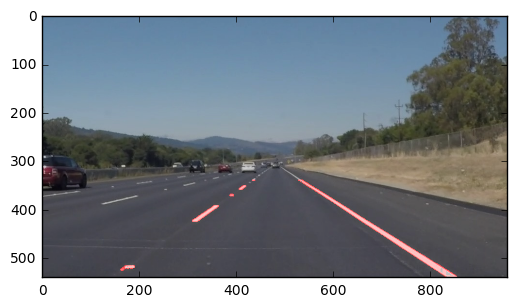

In [4]:
try:
    image = mpimg.imread('test_images/solidWhiteRight.jpg')
except FileNotFoundError as e:
    print(e)
    sys.exit(1)

result = process_image_no_slope(image)
plt.imshow(result)

In [17]:
white_output_no_slope = 'white_no_slope.mp4'
clip3 = VideoFileClip("solidWhiteRight.mp4")
white_clip1 = clip3.fl_image(process_image_no_slope) #NOTE: this function expects color images!!
%time white_clip1.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 221/222 [00:10<00:00, 15.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 12.6 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output_no_slope))

## Challenge

In [31]:
def process_image_challenge(image):
    """
    Returns processed image.

    Applies the following filter/transforms
    ---------------------------------------

    * Gray Scale
    * Gaussian Blur
    * Canny Transform
    * Masking the image
    * Hough Transform

    The output of this function is the combition of Hough lines and original image.

    Example
    -------

    For image

    >>> try:
    >>>    image = mpimg.imread('test_images/solidWhiteRight.jpg')
    >>> except FileNotFoundError as e:
    >>>    print(e)
    >>> result = process_image(image)
    >>> plt.imshow(result)
    """

    # Converting the image into gray scale
    gray_image = grayscale(image)

    # Applying Gaussian blur to the gray scaled image
    kernel_size = 5
    gaussian_blur_image = gaussian_blur(gray_image, kernel_size)

    # Applying Canny transform to the image
    low_threshold = 50
    high_threshold = 150
    edges_image = canny(gaussian_blur_image, low_threshold, high_threshold)

    # Masking the image
    imshape = image.shape
    vertices = vertices = np.array([[(200, 680), (470, 550), (850, 550), (1100, 680)]], dtype=np.int32)
    masked_edges = region_of_interest(edges_image, vertices)

    # Applying Hough transform to masked image
    rho = 2
    theta = np.pi/180
    threshold = 50
    min_line_length = 10
    max_line_gap = 20
    hough_lines_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len=min_line_length,
                                    max_line_gap=max_line_gap)
    result = weighted_img(hough_lines_image, image)

    return result

In [32]:
try:
    image = mpimg.imread('challenge.jpg')
except FileNotFoundError as e:
    print(e)
    sys.exit(1)

result = process_image_challenge(image)
plt.imshow(result)

ValueError: cannot convert float NaN to integer

## Reflection

After separating the two lanes, I get into intercept and slope of each of the lanes/lines. From slope and intercept, I find the coefficient, then using the coefficients and intercepts, I then get the intersection of `x`. With the `x` intersection coordinate and the intercept (positive and negative), I draw the line.

Initially, the two lines are joined at the centre due to `x` intersection, but to make them separate I used `Intercept Law` and remove the `x` intersection.

### Improvements

1. For the white lines video:
    
    I would rather use a linear regression to fit the line, maybe by using [scikit-learn](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html) or to make it more special for the curves I would use non-linear regression to add a smooth curve.  

2. For the yellow and white lines video:

    In my opinion, I wanted to apply two masking layers, one for yellow line and the other for the white line. Extracting the yellow feature using `cv2.inRange()` would be a better choice. Again I am not sure on how to use this.